# Определение перспективного тарифа для телеком компании

В данном проекте я буду действовать как аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
В этом проекте предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Получение и предобрабока данных

Начнем с импорта необходимых инструментов для последующего анализа и загрузки баз данных, с которыми предстоит работать

In [1]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats as st
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

Посмотрим на данные, которыми располагаем. Для наглядности, каждый датафрейм будет отображен отдельно

In [2]:
display(df_calls.sample(10))
display(df_calls.info())

,id,call_date,duration,user_id
24925,1063_454,2018-09-23,3.67,1063
105095,1270_87,2018-09-16,18.47,1270
45642,1114_50,2018-12-23,4.78,1114
167344,1412_261,2018-07-24,5.11,1412
21042,1055_535,2018-11-10,10.18,1055
6517,1018_305,2018-12-07,11.82,1018
54549,1137_70,2018-12-31,14.98,1137
173002,1427_366,2018-11-19,10.21,1427
173766,1429_235,2018-01-26,6.48,1429
9227,1024_258,2018-11-21,5.84,1024


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

Чтож, начнем с хорошего - пропусков нет. Однако есть звонки длительностью 0 минут и столбец с датой звонка имеет не верный тип данных. Начнем с исправления ошибок в этом датафрейме, а потом познакомимся с другими

Познакомимся поподробнее с полученными данными. Интересно, что же скрывается внутри?..

Для этого построим гистограмму длительности звонков и попробуем проанализировать полученную картину.

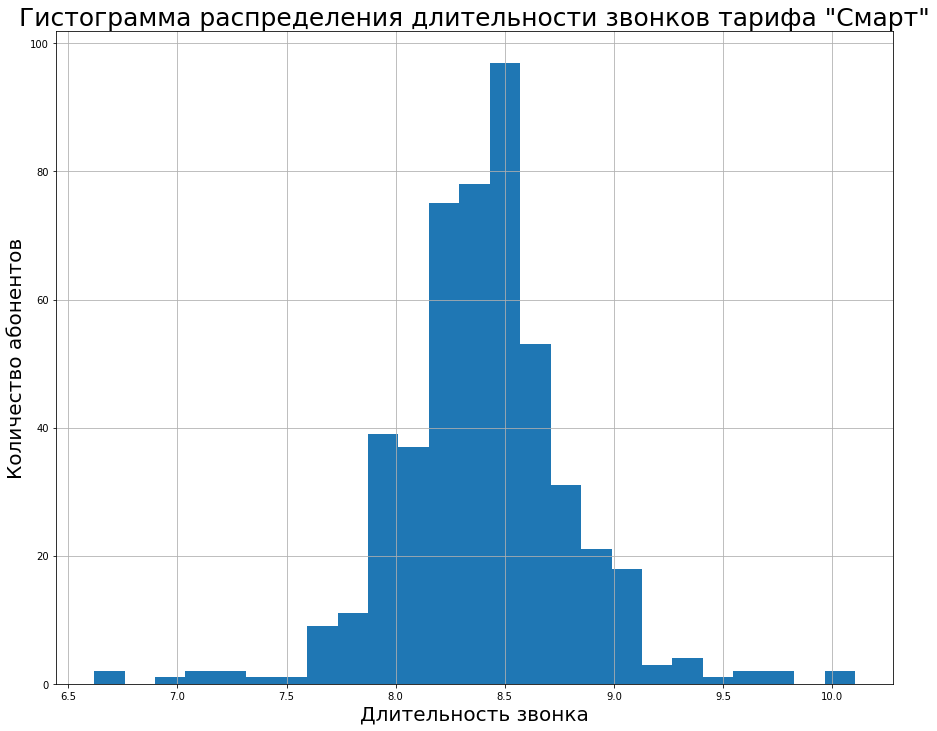

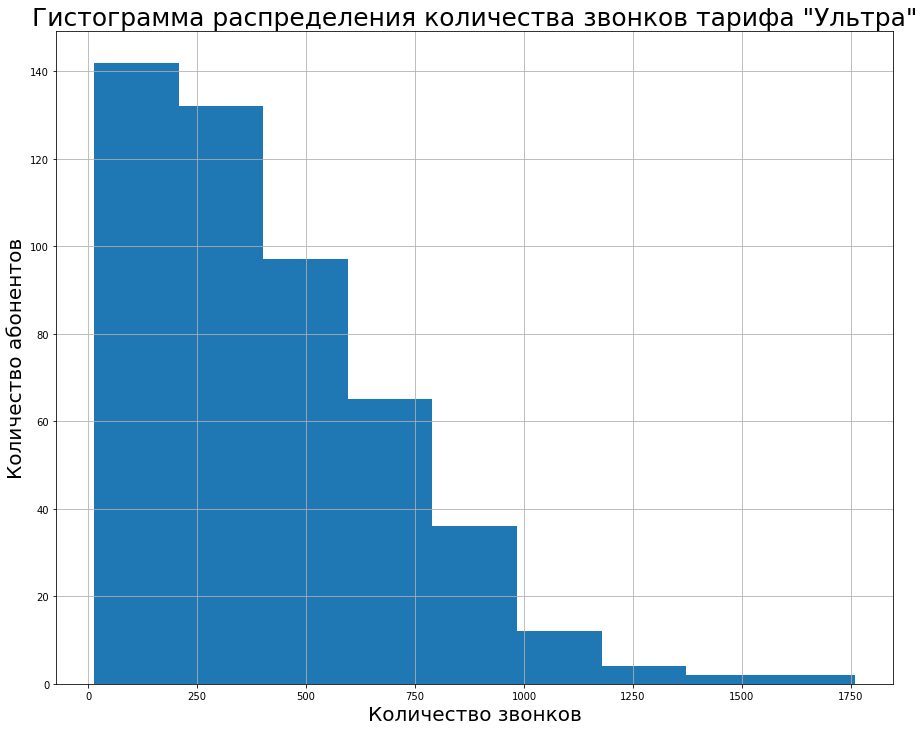

In [4]:
df_calls.query('duration != 0').pivot_table(index = 'user_id',
                        values = 'duration', aggfunc = 'mean').hist(bins = 25, figsize = (15,12))
plt.title('Гистограмма распределения длительности звонков тарифа "Смарт"', loc='center', fontsize = '25')
plt.xlabel('Длительность звонка', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
df_calls.pivot_table(index = 'user_id', values = 'duration', aggfunc = 'count').hist(bins = 9, figsize = (15,12))
plt.title('Гистограмма распределения количества звонков тарифа "Ультра"', loc='center', fontsize = '25')
plt.xlabel('Количество звонков', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()

Полученная гистограмма распределилась нормально. В среднем, абоненты совершают звонти длительностью до 8ми c половиной минут. Однако, существует достаточное количество звонков с нулевой длительностью, которые я отбросил для корректного анализа распределения длительности. О чем говорят такие значени? Скорее всего, абонент не подошел к телефону и звонок просто пропущеный. Как один из вариантов - сброс спама(правда, чаще требуется хотя бы секунда-другая, чтобы понять, что цель звонящего - спам), но это меньше похоже на правду.

А еще в нашей компании есть особенно популярные абоненты - количество звонков достигает 1750! Правда, это за весь год. Может, эти люди жертвы коллекторов? Или просто очень любят поболтать. В любом случае, их очень мало и на репрезентативность выборки они не повлияют.

In [5]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls['month'] = df_calls['call_date'].dt.month
#def roundation(val):
#    val = mt.ceil(val)
#    return val
#df_calls['duration'] = df_calls['duration'].apply(roundation)
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
display(df_calls.duplicated().value_counts())
#display(df_calls['duration'].value_counts())
display(df_calls)

False    202607
dtype: int64

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


Первым делом разберемся с форматом даты - сделаем её соответствующего типа. Затем, для простоты последнующего анализа, выделим новый столбец с ссылкой на месяц, когда звонок был совершен. А еще мы знаем, что длительность звонков округляется в большую сторону - учтем и это сразу округлив все значения в столбце длительности. С нулевыми значениями, на мой взгляд, нет смысла что-то предпринимать - на конечную сумму уплаты по тарифу они не повлияют. Посмотрим на новый датафрейм - красота!

In [6]:
display(df_internet.sample(10))
display(df_internet.info())

,Unnamed: 0,id,mb_used,session_date,user_id
41571,41571,1145_307,0.00,2018-05-14,1145
122466,122466,1412_340,289.46,2018-06-08,1412
142880,142880,1478_244,287.25,2018-12-13,1478
136785,136785,1458_163,1090.71,2018-06-08,1458
113797,113797,1385_5,840.51,2018-09-24,1385
83712,83712,1284_66,338.78,2018-07-27,1284
63521,63521,1217_89,448.24,2018-12-12,1217
148660,148660,1496_608,387.19,2018-09-07,1496
27303,27303,1094_165,592.56,2018-07-10,1094
102510,102510,1344_91,366.28,2018-06-02,1344


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

Идем далее, разберемся, что там с интернетом. А тут появляется "битый" столбец. Проблема с форматом даты мигрирует в этот датафрейм из первого, а данные по трафику, как и в случае с минутами, сразу округлим в большую сторону. Кстати, как и с первым датафреймом, я решил проверить наличие дубликатов - к счастью, их не обнаружилось ни там, ни тут. И снова выделим стобец с месяцами - чтобы далее об этом не переживать.

In [7]:
df_internet = df_internet.drop('Unnamed: 0', axis = 1)

In [8]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet['month'] = df_internet['session_date'].dt.month
#df_internet['mb_used'] = df_internet['mb_used'].apply(roundation)
df_internet['mb_used'] = np.ceil(df_internet['mb_used']).astype(int)
#display(df_internet)
#display(df_internet['mb_used'].value_counts())

display(df_internet.duplicated().value_counts())
display(df_internet.info())

False    149396
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
id              149396 non-null object
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
month           149396 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.7+ MB


None

Так гораздо лучше! Двигаемся дальше.

Аналогично датафрейму с длительностью звонков, посмотрим на данные по интернет сессиям внимательнее. Для этого построим гистограмму.

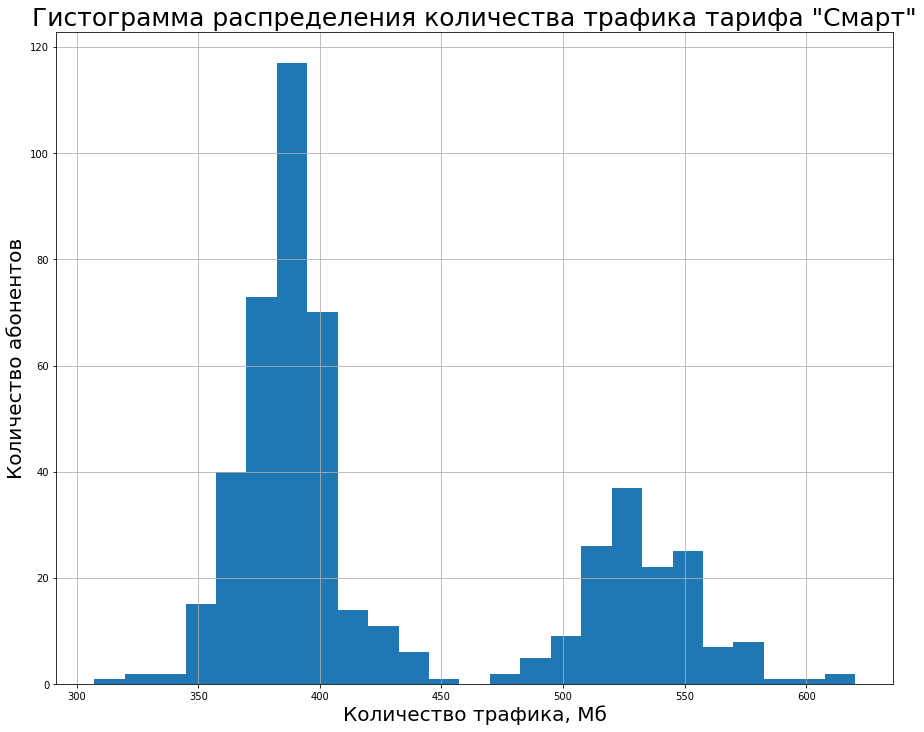

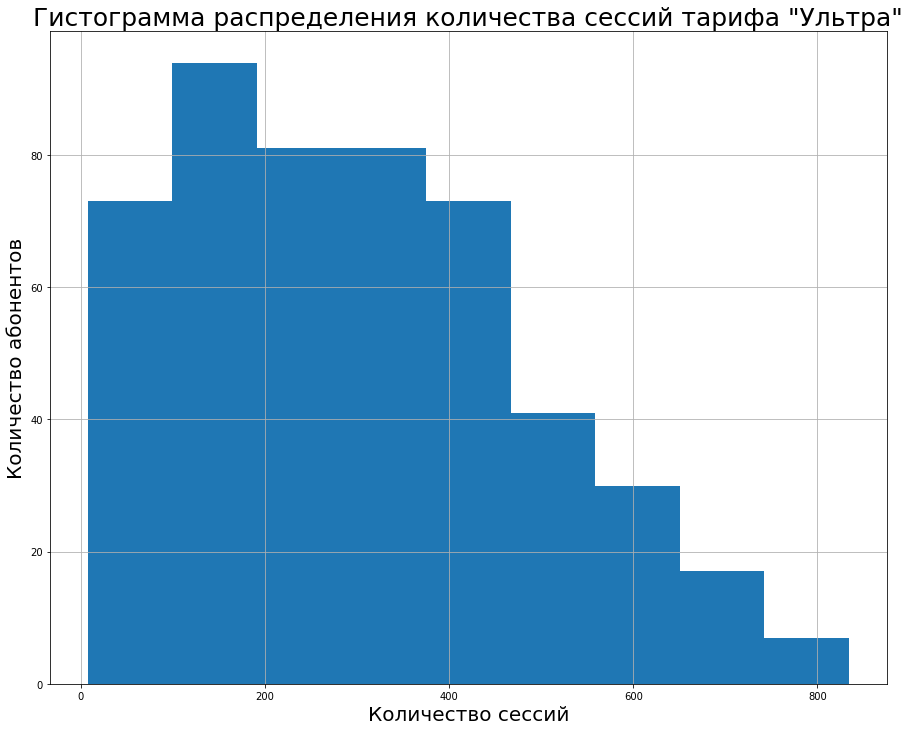

In [9]:
df_internet.query('mb_used != 0').pivot_table(index = 'user_id', 
                        values = 'mb_used', aggfunc = 'mean').hist(bins = 25, figsize = (15,12))
plt.title('Гистограмма распределения количества трафика тарифа "Смарт"', loc='center', fontsize = '25')
plt.xlabel('Количество трафика, Мб', size = 20)
plt.ylabel('Количество абонентов', size = 20)
plt.show()
df_internet.pivot_table(index = 'user_id', values = 'mb_used', aggfunc = 'count').hist(bins = 9, figsize = (15,12))
plt.title('Гистограмма распределения количества сессий тарифа "Ультра"', loc='center', fontsize = '25')
plt.xlabel('Количество сессий', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
#display(df_internet.query('mb_used == 0').groupby('user_id').count())

Ситуация с данными по интернету не такая однозначная и гладкая, как со звонками. Во-первых, на гистограмме распределения среднего потраченного трафика появилось 2 пика - первый вокруг, примерно, 370 Мб, второй, существенно меньший, вокруг 525 Мб. Во-вторых, на графике количества сессий есть странный выброс вокруг значения 50 сессий, а дальше подозрительный выброс в районе 600. Что можно сказать глядя на эти зависимости?

Первое, что приходит в голову, когда мы видим два пика на гистограмме распределения - взяты данные разных величин, не связанных между собой. Однако, постойте. У нас ведь два разных тарифаи, очевидно, что пользователей тарифа "Ультра" будет меньше, а трафик, который они используют, почти наверняка будет выше. Скорее всего, дело как раз в этом. Также, стоит принять во внимание, что многие абоненты могли быть подключены к тарифу во второй половине года, например, после агрессивной пиар-компании оператора. Тогда наплыв новичков мог спровоцировать пик в районе меньшего значения среднего трафика, в то время как старожилы расположились дальше.

Что касается странных пиков на второй гистограмме, тут всё сложнее. Первый пик в районе 50ти-60ти. Выходит, что 45 человек заходили в интернет 5 раз в месяц, примерно раз в неделю (1.1, но округлим в меньшую сторону, зайти в интернет на 10% - это интересно). Второй пик в районе 600 сессий, это 11 раз в неделю. Возможно, такие симкарты принадлежат корпоративным клиентам, которые выходят в интернет только по рабочим задачам. А может дело снова в неодновременности начала пользованием тарифами Мегалайна. Так или иначе, больше всего нас интересует длительность сессии, так как именно трафик определяет стоимость выхода в интернет. Средние значения не выбиваются за "рамки дозволенного" - для тарифа "Смарт" предоплачиваются вместе с абонентской платой 15Гб трафика, а максимальное среднее на гистограмме - 600 Мб. Вполне себе правдоподобная картина. Стоит ли отбрасывать второй пик? Для получения более объективной картины не стоит. Конечно, было бы гораздо удобнее, если бы пользователи, которых мы исследуем, были подключены к оператору в одно и то же время, но, к сожалению, таких удобных и красивых данных у нас нет. Количество сессий на цель нашего проекта не влияет - плата не зависит от количества раз посещения интернета, а потому и тратить время на обработку таких аномалий не имеет большого смысла. Но как объяснить нулевые значения трафика в сессию? Несколько вариантов, откуда таковые могли взяться. Прежде всего, предоплаченный трафки закончился и пользователь попадает на страницу с предложением продлить пакет или оплатить гигабайты сверх тарифа. Еще одним вариантом объяснения природы таких сессий может быть дополнительные опции, такие как безлимитные мессенджеры и т.д. В таком случае подключение к интрнету будет зафиксировано, а трафик не учтен, что приведет к нулевой сессии. Так как информации о дополнительных опциях не дано, такой вариант менее вероятен. Еще из возможных вариантов может такая ситуация: у пользователя на телефоне включен и мобильный интернет и вайфайю В момент разблокировки мобильный интернет подключается несколько быстрее, чем ваайфай, который при передаче данных находится в приоритете. В итоге, получается, что мобильный интернет разотал секунду, но данные по нему не были отправлены, что привело  к нулевой сессии. Как мной было описано выше, нулевые сессии на стоимость пакета не влияют, а значит и отбраковывать их нет большого смысла.

In [10]:
display(df_messages.sample(10))
display(df_messages.info())

,id,message_date,user_id
76892,1324_575,2018-08-02,1324
74287,1314_138,2018-03-11,1314
47286,1209_220,2018-10-09,1209
58411,1257_203,2018-08-13,1257
75478,1319_67,2018-10-17,1319
61728,1271_313,2018-11-10,1271
108889,1438_61,2018-10-18,1438
109295,1440_236,2018-05-29,1440
95878,1393_452,2018-09-30,1393
62978,1274_564,2018-05-23,1274


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

И снова формат даты, и снова добавляем месяц, и снова дубликаты...

In [11]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages['month'] = df_messages['message_date'].dt.month
display(df_messages.duplicated().value_counts())
display(df_messages.info())

False    123036
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
month           123036 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


None

Слудеющий датафрейм содержит информацию по тарифам. Тут никаких ошибок нет, поэтому и исправлять ничего не будем, просто полюбуемся, порадуемся и двинемся дальше.

In [12]:
display(df_tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Последний датафрейм - это данные о пользователях. Тут имеются пропущеные значения в столбце "дата расторжения", но заполнять их мы не будем - скорее всего пропуски говорят нам о том, что пользователь еще пользуется выбранным тарифом.

In [13]:
display(df_users.sample(10))
display(df_users.info())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
398,1398,58,NaN,Махачкала,Рауль,Ахмедов,2018-12-06,smart
147,1147,63,NaN,Якутск,Владимир,Синицын,2018-07-09,smart
422,1422,60,2018-12-21,Москва,Клара,Устинова,2018-10-12,smart
488,1488,47,NaN,Новороссийск,Вадим,Филатов,2018-11-07,smart
90,1090,54,2018-12-03,Череповец,Екатерина,Астафьева,2018-10-11,ultra
314,1314,27,NaN,Киров,Максим,Амелишко,2018-03-04,smart
275,1275,48,NaN,Москва,Семён,Елизаров,2018-04-24,smart
465,1465,41,NaN,Омск,Пётр,Ёркин,2018-04-14,smart
167,1167,30,NaN,Кемерово,Клавдия,Абдулина,2018-09-29,ultra
452,1452,74,NaN,Москва,Эмилия,Абалдуева,2018-06-19,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

Для будущих операций с нашими данными к датафрейму "пользователи" я добавил столбец с id тарифа - 0 если smart и 1 если ultra. Зачем? Да просто для простоты. С числами в любом виде работать удобнее.

In [14]:
df_users['tariff_id'] = df_users['tariff'].apply(lambda x: x == 'ultra')*1
display(df_users.sample(10))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id
143,1143,64,NaN,Пермь,Арсен,Покровский,2018-04-27,ultra,1
225,1225,71,NaN,Оренбург,Даниэла,Горбачева,2018-04-26,ultra,1
210,1210,33,NaN,Севастополь,Евфросинья,Серебрякова,2018-07-29,smart,0
298,1298,29,NaN,Новосибирск,Надежда,Чеснокова,2018-07-26,smart,0
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,1
307,1307,53,NaN,Самара,Симона,Авсейкина,2018-05-04,smart,0
430,1430,22,NaN,Тверь,Андрей,Авроров,2018-04-23,ultra,1
129,1129,48,NaN,Курган,Анвар,Морозов,2018-12-17,smart,0
490,1490,30,NaN,Москва,Радомир,Алесин,2018-04-03,smart,0
112,1112,51,NaN,Ульяновск,Арнольд,Казанцев,2018-09-04,smart,0


Теперь исправим типы данных в этом датафрейме - даты подлючения и окончания действия тарифа опять в неправильном формате. А еще проверим, что во всех колонках нет каких-либо очевидных аномалий и попытаемся найти дубликаты. Спойлер: дубликатов нет. Но нам это только на руку.

In [15]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
#display(df_users['age'].value_counts())
#display(df_users['city'].value_counts())
#display(df_users['first_name'].value_counts())
#display(df_users['last_name'].value_counts())
#display(df_users['tariff'].value_counts())
display(df_users.duplicated().value_counts())
display(df_users.info())

False    500
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
tariff_id     500 non-null int64
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 35.3+ KB


None

Чтож, данные изучены, обработаны и обдуманы. Пора приступать к анализу.

## Поведение пользователей по месяцам

Для начала выясним, сколько каждый пользователь делает звонков и тратит минут в месяц. Построим сводную таблицу и внимательно изучим полученные данные

In [16]:
calls = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
calls.columns = ['user_id', 'month', 'calls_count', 'calls_sum']
display(calls.sample(10))

,user_id,month,calls_count,calls_sum
2161,1345,6,46,346
2980,1468,9,30,177
708,1114,7,12,80
966,1155,4,45,288
1192,1188,4,3,35
2878,1454,6,67,519
1813,1290,12,69,452
1656,1266,7,22,136
1487,1239,7,58,477
952,1152,12,54,415


Чаще всего, чем больше абонент является абонентом - тем чаще и больше он пользуется услугами. А что с сообщениями?

In [17]:
messages = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc=['count']).reset_index()
messages.columns = ['user_id', 'month', 'messages_count']
display(messages.sample(10))

,user_id,month,messages_count
1611,1311,11,66
133,1025,4,27
1906,1364,10,109
1341,1263,10,8
1112,1213,11,56
1397,1272,11,78
2150,1402,3,27
47,1007,11,21
254,1047,11,66
2504,1464,5,21


С сообщениями ситуация похожа. Теперь изучим интернет трафик. Для простоты последующего анализа переведем мегабайты в гигабайты и округлим в большую сторону - такова политика "Мегалайна".

In [18]:
internet = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['sum']).reset_index()
internet.columns = ['user_id', 'month', 'Gb_sum']
internet['Gb_sum'] = np.ceil(internet['Gb_sum']/1024).astype('int')
display(internet.sample(10))

,user_id,month,Gb_sum
632,1099,11,17
3164,1492,9,21
459,1072,4,25
1661,1263,7,15
1171,1182,12,28
1250,1195,10,8
1281,1200,8,16
689,1109,3,15
247,1039,10,24
674,1106,7,22


С интернетом ситуация несколько иная. Похоже, что маньшее число трафика расходуется в месяц подключения тарифа и отключения. В остальном, данные примерно одинаковые(для кадого пользователя, разумеется). Из датафрейма о пользователях выделим стоблцы c id пользователей и соответствуюих таифов.

In [19]:
tariff = df_users[['user_id', 'tariff_id']]
display(tariff.sample(10))

,user_id,tariff_id
221,1221,0
317,1317,0
414,1414,0
419,1419,0
106,1106,1
302,1302,0
448,1448,0
325,1325,1
88,1088,0
258,1258,0


Теперь объеденим данные в один датафрейм. Так будет удобнее выполнять последующий анализ. У всех таблиц есть одинаковые столбцы - id пользователя и id их тарифа. Копировать эту информацию нет никакого смысла, поэтому просто произведем объединение по этим столбцам.

In [20]:
df = calls.merge(messages, how = 'outer', on = ['user_id', 'month']).merge(internet,how = 'outer',
            on = ['user_id', 'month']).merge(tariff, how = 'outer', on = 'user_id')
display(df.sample(10))
display(df.tail(10))
display(df.info())

,user_id,month,calls_count,calls_sum,messages_count,Gb_sum,tariff_id
1681,1270,7.0,30.0,231.0,51.0,11.0,1
1680,1269,12.0,45.0,245.0,16.0,18.0,0
35,1005,6.0,80.0,612.0,47.0,10.0,0
1043,1168,6.0,128.0,912.0,40.0,32.0,1
215,1033,10.0,55.0,375.0,80.0,20.0,0
1532,1245,12.0,65.0,502.0,74.0,20.0,1
2550,1402,5.0,92.0,689.0,32.0,27.0,1
405,1064,7.0,47.0,313.0,37.0,21.0,0
3004,1471,12.0,108.0,815.0,85.0,11.0,1
3098,1483,11.0,89.0,613.0,47.0,17.0,0


,user_id,month,calls_count,calls_sum,messages_count,Gb_sum,tariff_id
3206,1473,10.0,NaN,NaN,20.0,14.0,1
3207,1473,11.0,NaN,NaN,14.0,22.0,1
3208,1473,12.0,NaN,NaN,20.0,18.0,1
3209,1489,8.0,NaN,NaN,17.0,11.0,0
3210,1489,9.0,NaN,NaN,32.0,17.0,0
3211,1489,10.0,NaN,NaN,21.0,20.0,0
3212,1489,11.0,NaN,NaN,20.0,18.0,0
3213,1489,12.0,NaN,NaN,35.0,17.0,0
3214,1128,NaN,NaN,NaN,NaN,NaN,1
3215,1371,NaN,NaN,NaN,NaN,NaN,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
user_id           3216 non-null int64
month             3214 non-null float64
calls_count       3174 non-null float64
calls_sum         3174 non-null float64
messages_count    2717 non-null float64
Gb_sum            3203 non-null float64
tariff_id         3216 non-null int64
dtypes: float64(5), int64(2)
memory usage: 201.0 KB


None

In [21]:
df['user_id'].nunique()

500

In [22]:
calls1= calls.set_index(['user_id', 'month'])
messages1 = messages.set_index(['user_id', 'month'])
internet1 = internet.set_index(['user_id', 'month'])
df2 = calls1.join(messages1, how = 'outer').join(internet1, how ='outer')

In [23]:
df2 = df2.reset_index()
df2['user_id'].nunique()

498

In [24]:
df2.shape

(3214, 6)

После объединения в датафрейме появились пустые значения - это пользователи, которые отдавали предпочтение одному из видов связи. Такие NaNы мы заменим нулями, так как по сути это соответствует действительности, если строка пропущена, значит расход по данной статье равен 0. Однако, стоит заметить в конце датафрейма две записи об абонентах, которые не пользовались услугами вообще. Никакими. Один из них пользователь тарифа "Смарт", второй - тарифа "Ультра". Просто отбросим этих пользователей и продолжим.

In [25]:
df = df.drop(df.index[[3214,3215]])
df = df.fillna(0)
df

,user_id,month,calls_count,calls_sum,messages_count,Gb_sum,tariff_id
0,1000,5.0,22.0,159.0,22.0,3.0,1
1,1000,6.0,43.0,172.0,60.0,23.0,1
2,1000,7.0,47.0,340.0,75.0,14.0,1
3,1000,8.0,52.0,408.0,81.0,14.0,1
4,1000,9.0,58.0,466.0,57.0,15.0,1
...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,0.0,17.0,11.0,0
3210,1489,9.0,0.0,0.0,32.0,17.0,0
3211,1489,10.0,0.0,0.0,21.0,20.0,0
3212,1489,11.0,0.0,0.0,20.0,18.0,0


Так гораздо лучше. Теперь можно переходить к слудеющему шагу.

А дальше самое интересное, посчитаем денги, которые каждый пользователь заносит оператору раз в месяц, полученные результаты добавим в конечный датафрейм.

In [26]:
def income(tariff_id, calls_sum, messages_count, Gb_sum):
    if tariff_id == 1:
        calls_over = calls_sum-df_tariffs['minutes_included'][1]
        if calls_over < 0:
            calls_cost = 0
        else:
            calls_cost = calls_over * df_tariffs['rub_per_minute'][1]
        messages_over = messages_count - df_tariffs['messages_included'][1]
        if messages_over < 0:
            messages_cost = 0
        else:
            messages_cost = messages_over * df_tariffs['rub_per_message'][1]
        Gb_over = Gb_sum - (df_tariffs['mb_per_month_included'][1]/1024)
        if Gb_over < 0:
            Gb_cost = 0
        else:
            Gb_cost = Gb_over * df_tariffs['rub_per_gb'][1]
        income = calls_cost + messages_cost + Gb_cost + df_tariffs['rub_monthly_fee'][1]
        return income
    else:
        calls_over = calls_sum-df_tariffs['minutes_included'][0]
        if calls_over < 0:
            calls_cost = 0
        else:
            calls_cost = calls_over * df_tariffs['rub_per_minute'][0]
        messages_over = messages_count - df_tariffs['messages_included'][0]
        if messages_over < 0:
            messages_cost = 0
        else:
            messages_cost = messages_over * df_tariffs['rub_per_message'][0]
        Gb_over = Gb_sum - (df_tariffs['mb_per_month_included'][0]/1024)
        if Gb_over < 0:
            Gb_cost = 0
        else:
            Gb_cost = Gb_over * df_tariffs['rub_per_gb'][0]
        income = calls_cost + messages_cost + Gb_cost + df_tariffs['rub_monthly_fee'][0]
        return income

for row in range(len(df)):
    df.loc[row, 'income_per_month'] = income(df.loc[row, 'tariff_id'], df.loc[row, 'calls_sum'],
                                         df.loc[row, 'messages_count'], df.loc[row, 'Gb_sum'])
display(df.sample(10))

,user_id,month,calls_count,calls_sum,messages_count,Gb_sum,tariff_id,income_per_month
1213,1190,12.0,66.0,445.0,20.0,12.0,0,550.0
1320,1209,6.0,41.0,291.0,73.0,17.0,0,1019.0
2445,1386,12.0,62.0,492.0,40.0,20.0,0,1550.0
2978,1468,6.0,28.0,211.0,5.0,17.0,0,950.0
1262,1200,6.0,83.0,567.0,44.0,19.0,1,1950.0
53,1007,4.0,25.0,198.0,11.0,8.0,0,550.0
2053,1327,9.0,61.0,462.0,45.0,16.0,0,750.0
286,1045,12.0,36.0,256.0,49.0,19.0,0,1350.0
1858,1296,10.0,40.0,316.0,45.0,15.0,0,550.0
2245,1360,4.0,117.0,802.0,0.0,12.0,1,1950.0


На данном этапе мы окончательно подготовили данные к "глубокому анализу" и можем приступить в ответу на поставленный в начале проекта вопрос - какой же тариф, в итоге, окажется лучше.

## Анализ данных

Приступим к анализу поведения клиентов. Сначала посмотрим на общую картину, затем перейдем к частностям.

In [27]:
df_stat_info = df.groupby('tariff_id')[['calls_sum','messages_count','Gb_sum',
        'income_per_month']].agg({'mean', np.var, np.std}).astype('int')
display(df_stat_info)

calls_sum           messages_count          Gb_sum           \
                var mean  std            var mean std    var mean std   
tariff_id                                                               
0             36219  417  190            796   33  28     33   16   5   
1            100873  526  317           2285   49  47     97   19   9   

          income_per_month             
                       var  mean  std  
tariff_id                              
0                   673931  1294  820  
1                   143491  2071  378

Какая интересная картина. О чем же она нам говорит? Ну, для начала в глаза бросаются огромные дисперсии. Это говорит нам о том, что в выборке некоторая часть пользователей пользуется тарифом усредненно, но большая часть делает упор на что-то одно - звонки, смс или интернет трафик. Очевидно отличается и среднее у анализируемых тарифов - это происходит как минимум потому, что включенное в абонентскую плату количество предоплаченных услуг отличается.

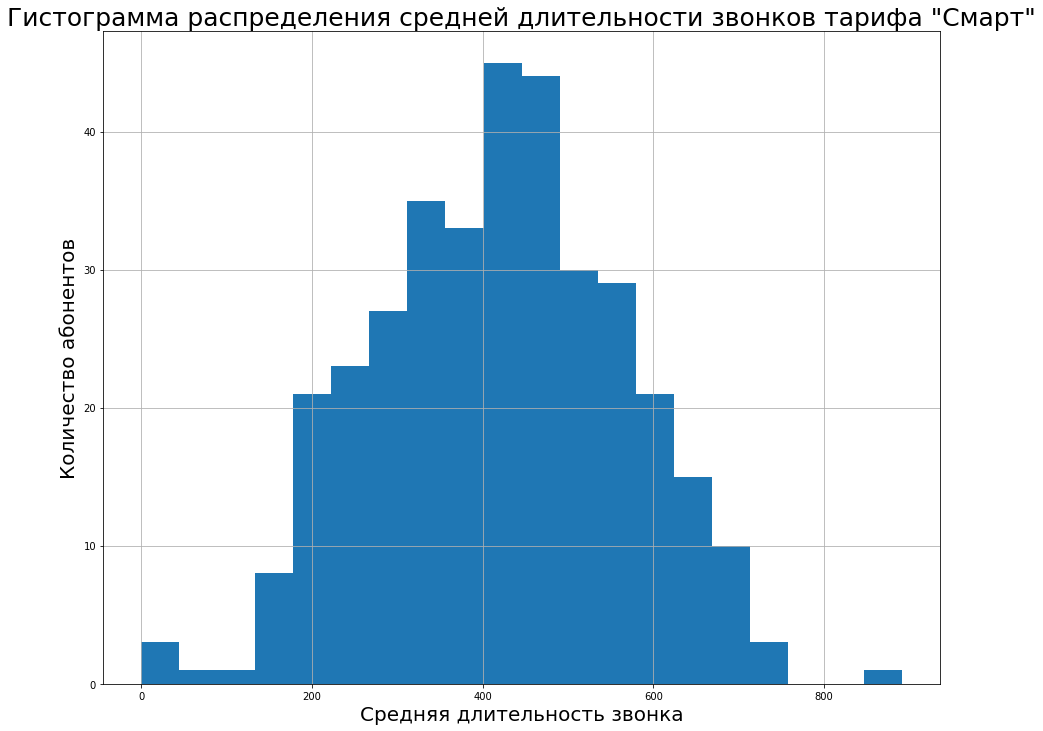

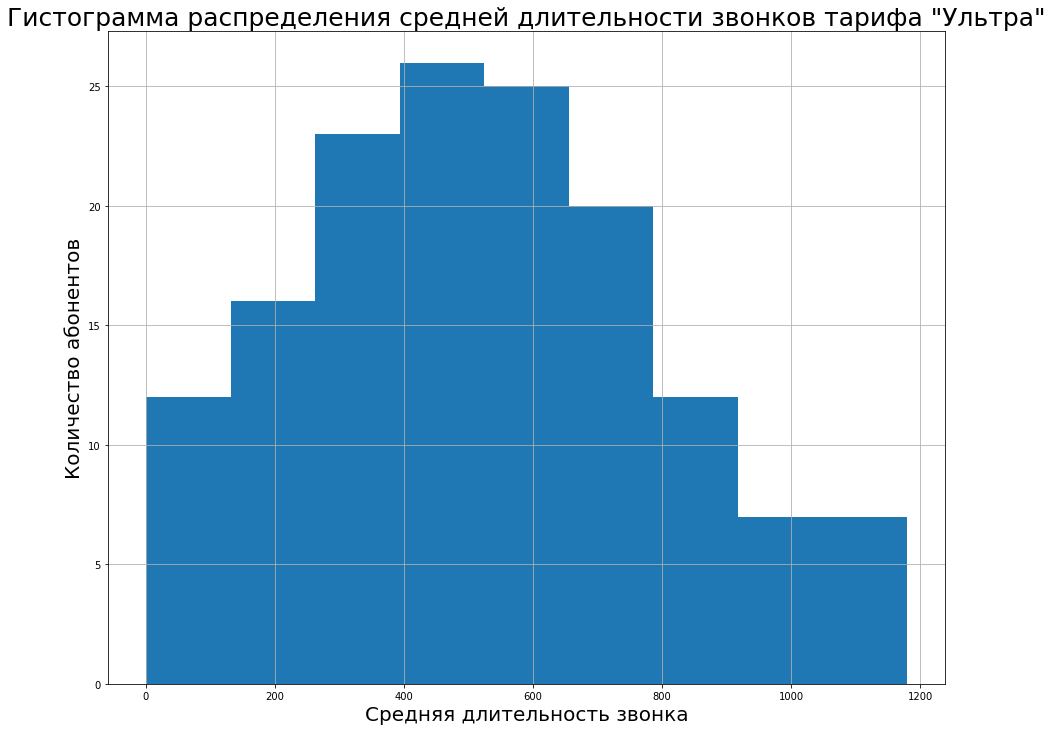

In [28]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values = 
                            'calls_sum', aggfunc = 'mean').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения средней длительности звонков тарифа "Смарт"', loc='center', fontsize = '25')
plt.xlabel('Средняя длительность звонка', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 
                                       'calls_sum', aggfunc = 'mean').hist(bins = 9, figsize = (15,12))
plt.title('Гистограмма распределения средней длительности звонков тарифа "Ультра"', loc='center', fontsize = '25')
plt.xlabel('Средняя длительность звонка', size = 20)
plt.ylabel('Количество абонентов', size = 20)
plt.show()

Для наглядности построим гистрограммы среднего значения потраченных минут по месяцам для обоих тарифов. Как видно из графиков, пользователи тарифа "Смарт" чаще всего используют ровно столько минут, сколько предполагается тарифом 550. Гистограмма немного скошена влево, значит большинство пользователей стараются не переусердствовать и не выйти за рамки ограничений. Для абонентов тарифа "Ультра" картина несколько отличается. Начнем с того, что, как ни странно, но среднее количество минут примерно совпадает с средним тарифа "Смарт". Однако, во втором случае, диаграмма скошена вправо. Оно и понятно, этот тариф предполагает до 3000 предоплаченных минут. Из характерных отличий графиков следует также отметить тот факт, что пользователи тарифоа "Ультра" вообще не прибегают к дополнительно оплачиваемым минутам, в то время как для тарифа "Смарт" это нормальная практика. Заметим, что оба распределения похожи на нормальные, что позволяет нам судить о репрезентативности полученной выборки.

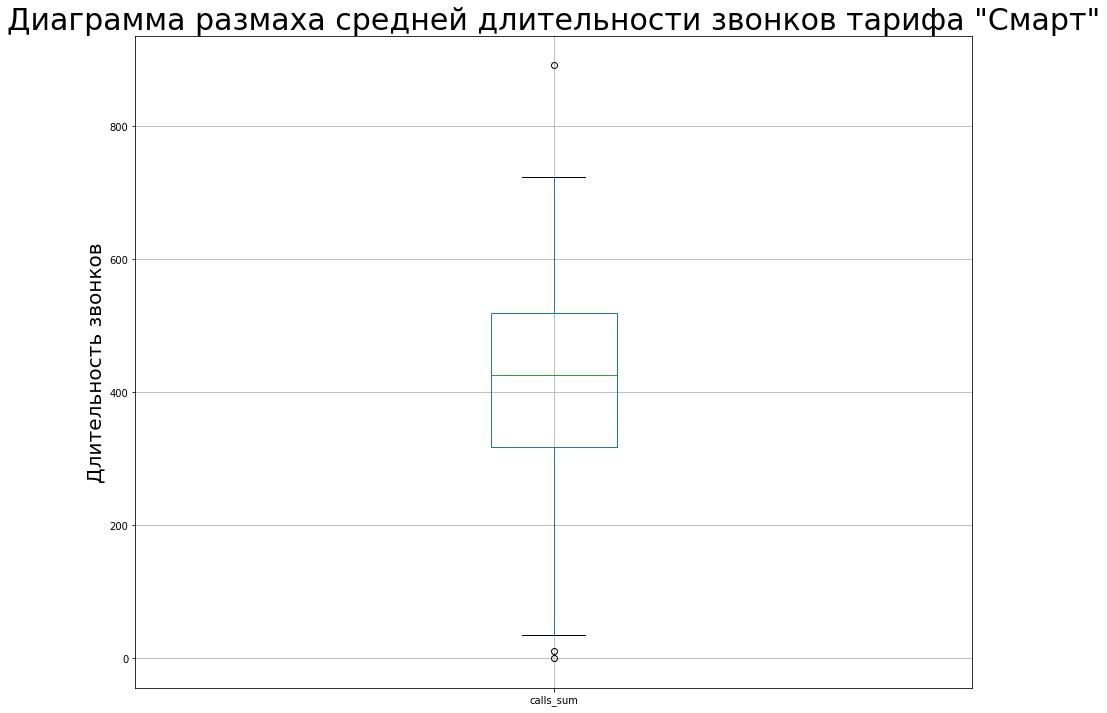

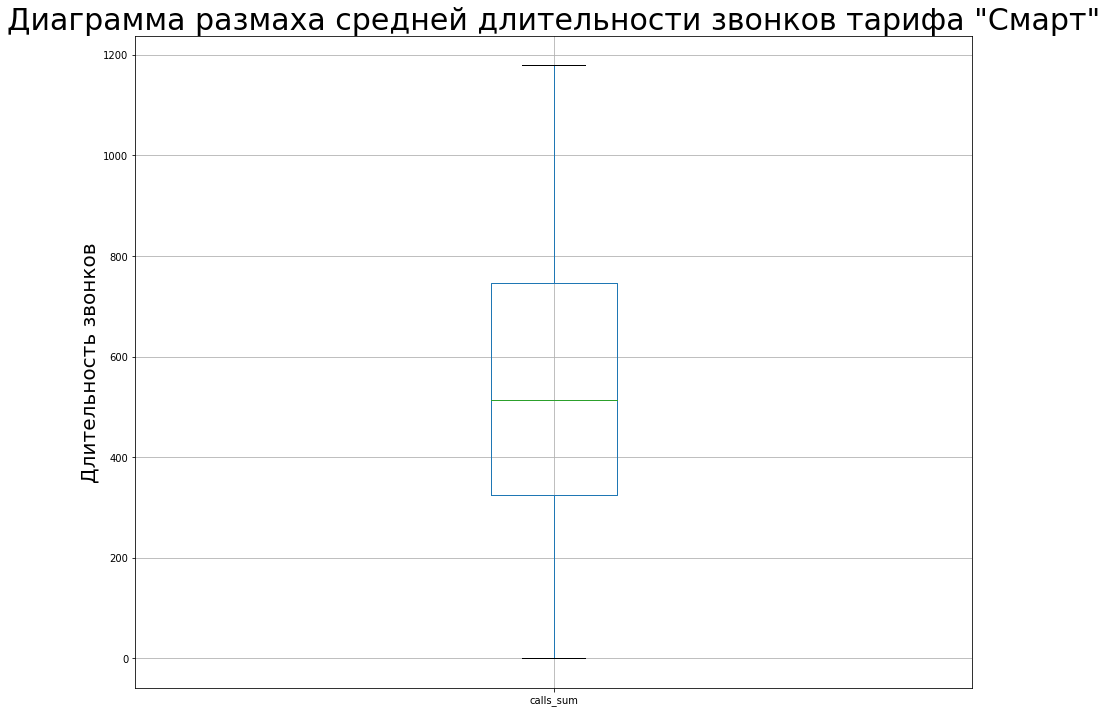

In [29]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values = 'calls_sum', aggfunc = 'mean').boxplot(figsize = (15,12))
plt.title('Диаграмма размаха средней длительности звонков тарифа "Смарт"', loc='center', fontsize = '30')
plt.ylabel('Длительность звонков', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 'calls_sum', aggfunc = 'mean').boxplot(figsize = (15,12))
plt.title('Диаграмма размаха средней длительности звонков тарифа "Смарт"', loc='center', fontsize = '30')
plt.ylabel('Длительность звонков', size = 20) 
plt.show()

Диаграмма размаха только подтверждает выше указанные предположения. А еще на ней видны пара выбросов для тарифа "Смарт" - вероятно, это люди, которые пыталоись сэкономить на абонентской плате =) Либо те, кто предпочитает интернет и смс общению по телефону.

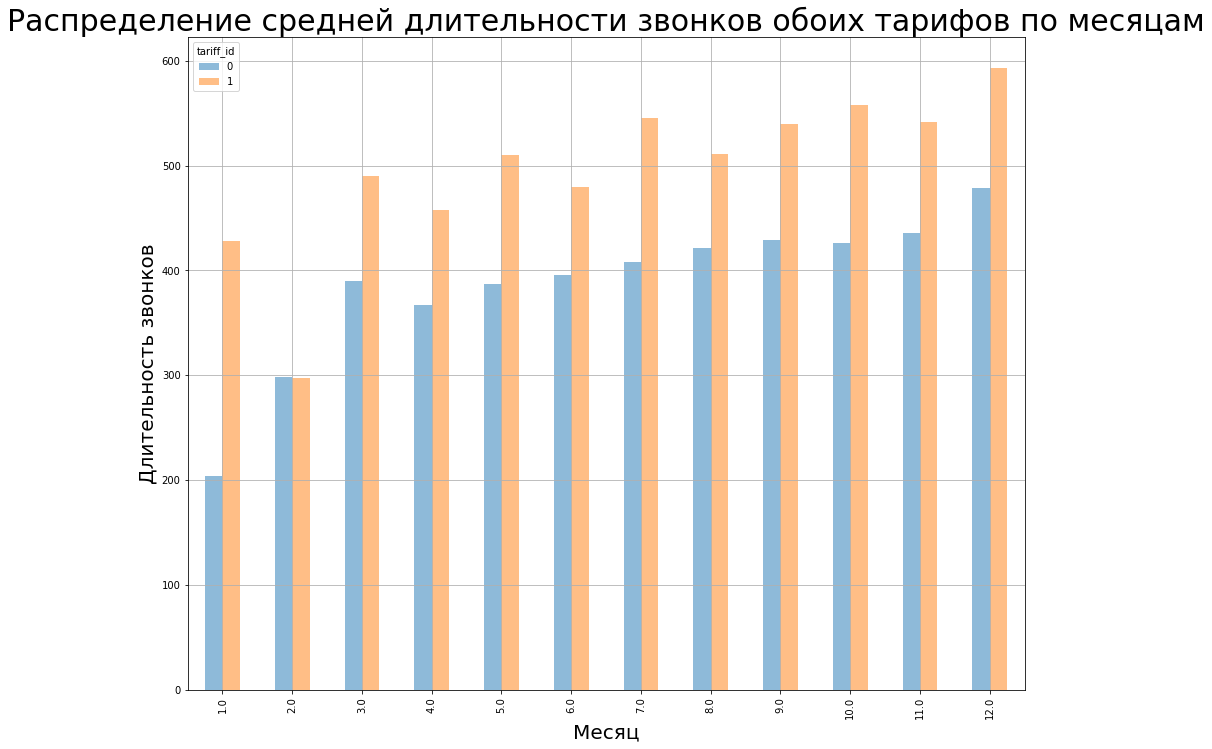

In [30]:
df.pivot_table(index='tariff_id', columns='month', values='calls_sum', 
               aggfunc='mean').T.plot(kind='bar', grid = True, alpha=0.5, figsize = (15,12))
plt.title('Распределение средней длительности звонков обоих тарифов по месяцам', loc='center', fontsize = '30')
plt.xlabel('Месяц', size = 20) 
plt.ylabel('Длительность звонков', size = 20) 
plt.show()

Интересным образом распределилась средняя длительность звонков соответствующих тарифов по меяцам: в основном абоненты тарифа "Смарт" звонили с марта по ноябрь, а в декабре небольшой скачок - оно и понятно, праздники.  Абоненты тарифа "Ултьра" чем-то невзлюбили февраль, звонков в этот месяц меньше всего. Декабрь аналогичным образом остается в лидерах. Остальные месяцы ± равны, среднее значение продолжительности звонков колеблется вокруг значения 500 минут.

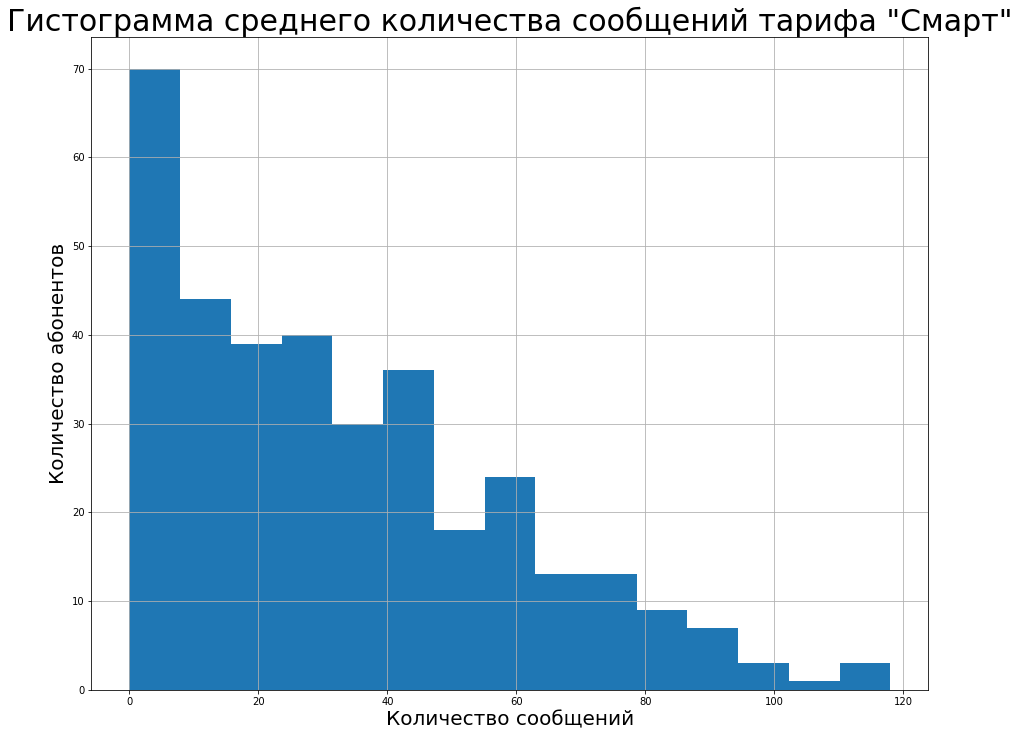

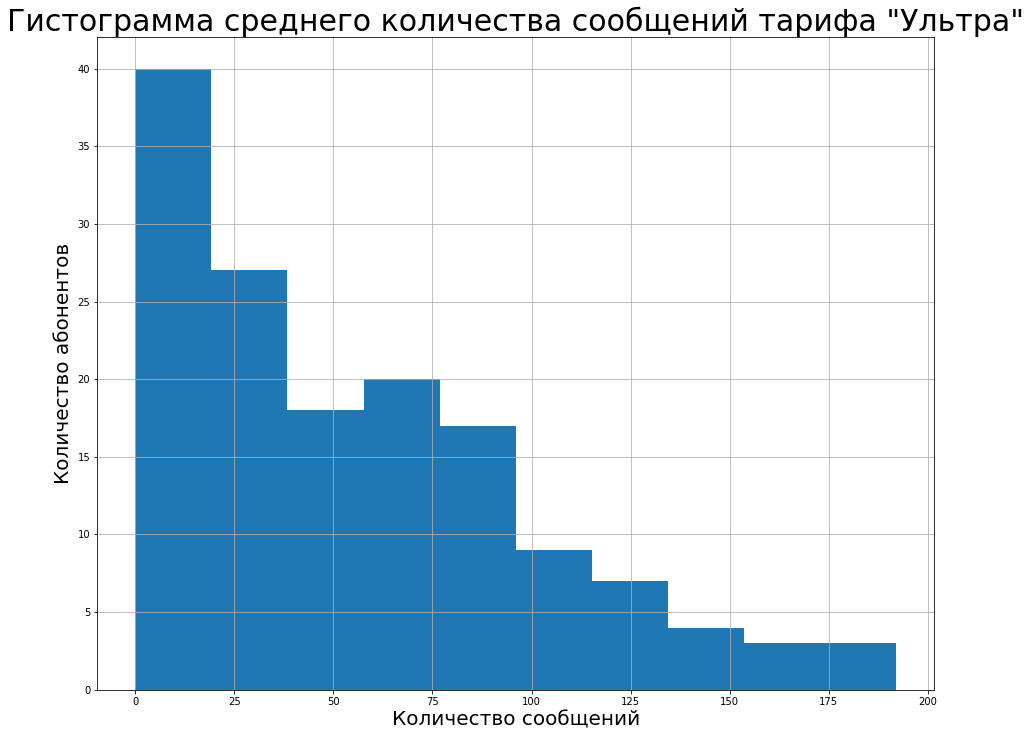

In [31]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values = 
                                'messages_count', aggfunc = 'mean').hist(bins = 15, figsize = (15,12))
plt.title('Гистограмма среднего количества сообщений тарифа "Смарт"', loc='center', fontsize = '30')
plt.ylabel('Количество абонентов', size = 20) 
plt.xlabel('Количество сообщений', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values =
                                'messages_count', aggfunc = 'mean').hist(bins = 10, figsize = (15,12))
plt.title('Гистограмма среднего количества сообщений тарифа "Ультра"', loc='center', fontsize = '30')
plt.ylabel('Количество абонентов', size = 20) 
plt.xlabel('Количество сообщений', size = 20) 
plt.show()

Пик колеблется вокруг 0 - оно и понятно, в эпоху интернета и месенджеров смс потихоньку отступают на второй план. Пользователи тарифа "Смарт" редко превышают установленный для них лимит, чаще всего они либо укладываются в него, либо не пользуются сообщениями вообще. А пользователи тарифа "Ультра" чаще всего либо вообще не пользуются смс, либо отправляют порядка 30ти - 60ти штук в месяц. Но лимит превысить не удалось никому.

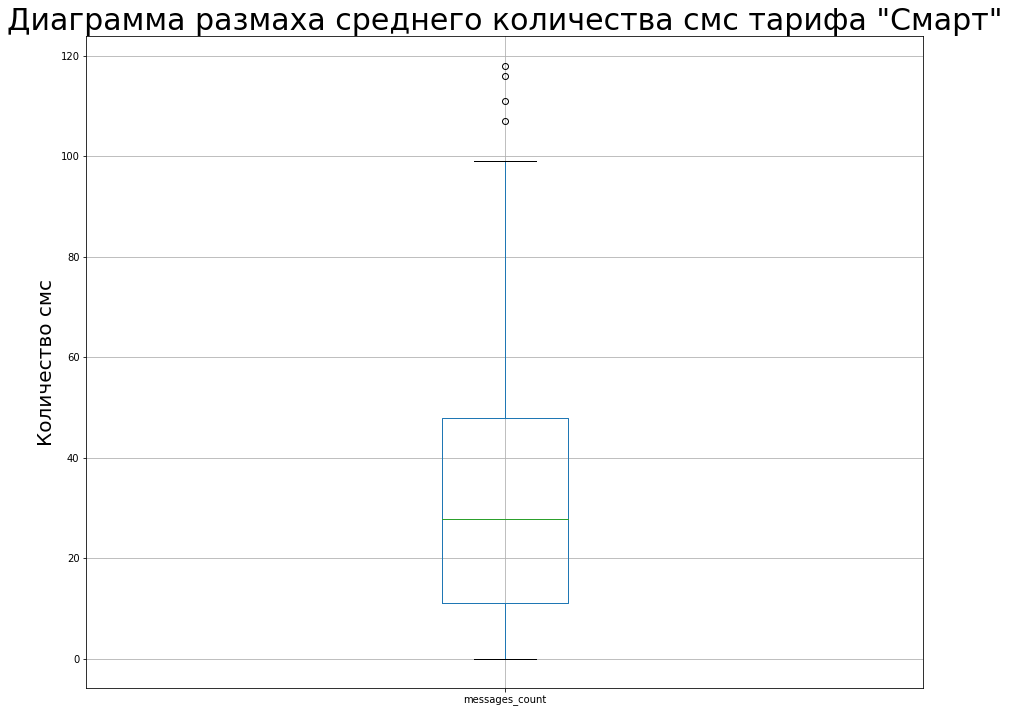

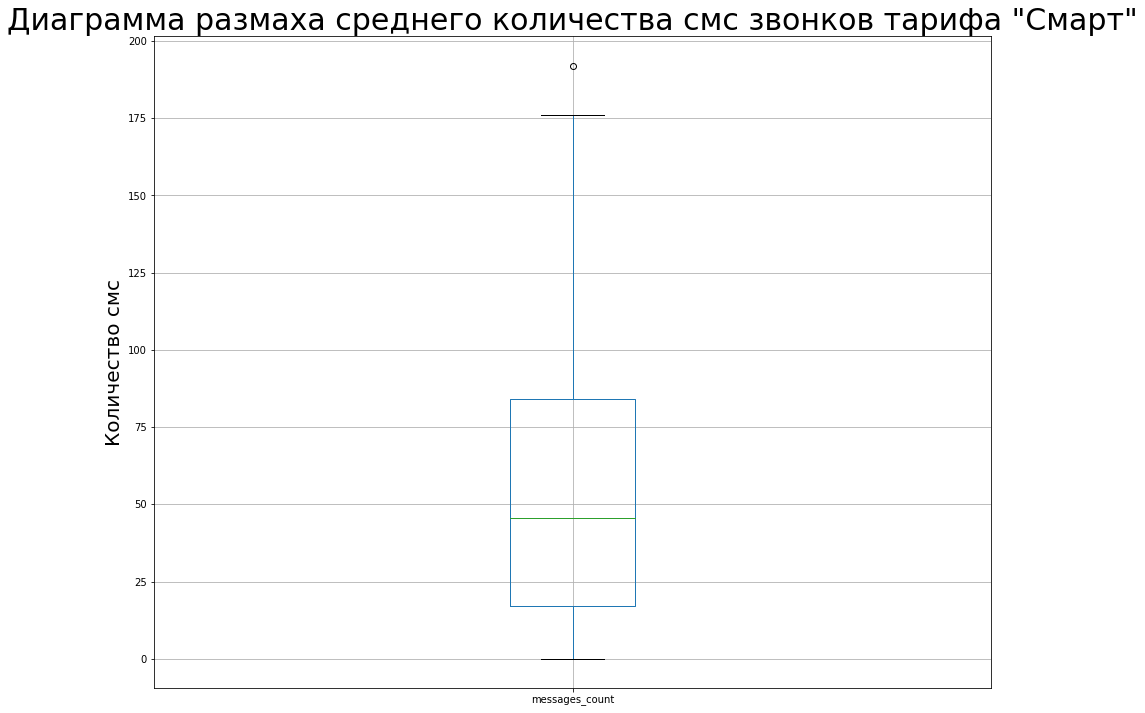

In [32]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values = 
                                       'messages_count', aggfunc = 'mean').boxplot(figsize = (15,12))
plt.title('Диаграмма размаха среднего количества смс тарифа "Смарт"', loc='center', fontsize = '30')
plt.ylabel('Количество смс', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 
                                      'messages_count', aggfunc = 'mean').boxplot(figsize = (15,12))
plt.title('Диаграмма размаха среднего количества смс звонков тарифа "Смарт"', loc='center', fontsize = '30')
plt.ylabel('Количество смс', size = 20) 
plt.show()

На диаграмме размеха видно, что для тарифа для обоих тарифов есть выбросы, однако на первом их больше. Может, кто-то поругался с девушкой, заблокировавшей его в соцсетях или просто приверженец олдскула?..

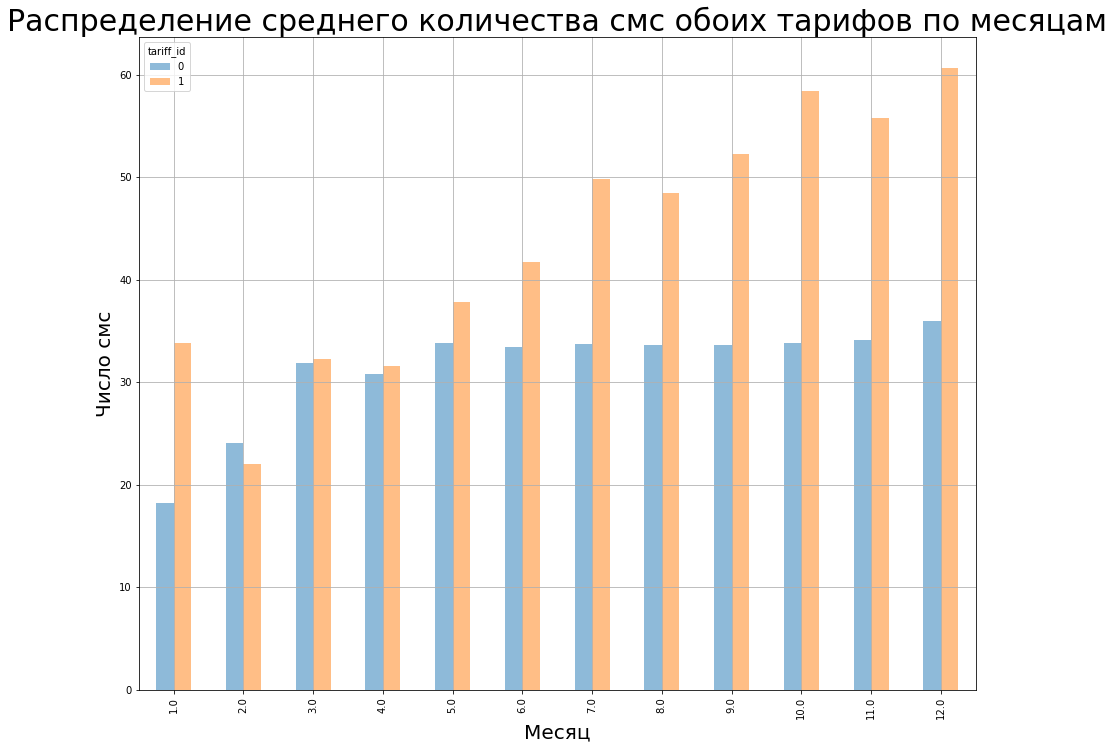

In [33]:
df.pivot_table(index='tariff_id', columns='month', values='messages_count',
               aggfunc='mean').T.plot(kind='bar', alpha=0.5, grid = True, figsize = (15,12))
plt.title('Распределение среднего количества смс обоих тарифов по месяцам', loc='center', fontsize = '30')
plt.xlabel('Месяц', size = 20) 
plt.ylabel('Число смс', size = 20) 
plt.show()

А вот в ситуации с смсками относительно распределения звонков по месяцам картина отличается. Чем ближе конец года, тем активнее смсят пользователи тарифа "Ультра". В начале года наблюдается провал, даже более того, пользователи тарифа "Смарт" в феврале в среднем смсят больше. Зато весь остальной год налюдается стабильный рост. А для абонентов "Смарта" картина иная, январь и февраль простаивают, но весь остальной год в среднем колеблется вокруг одного значения.

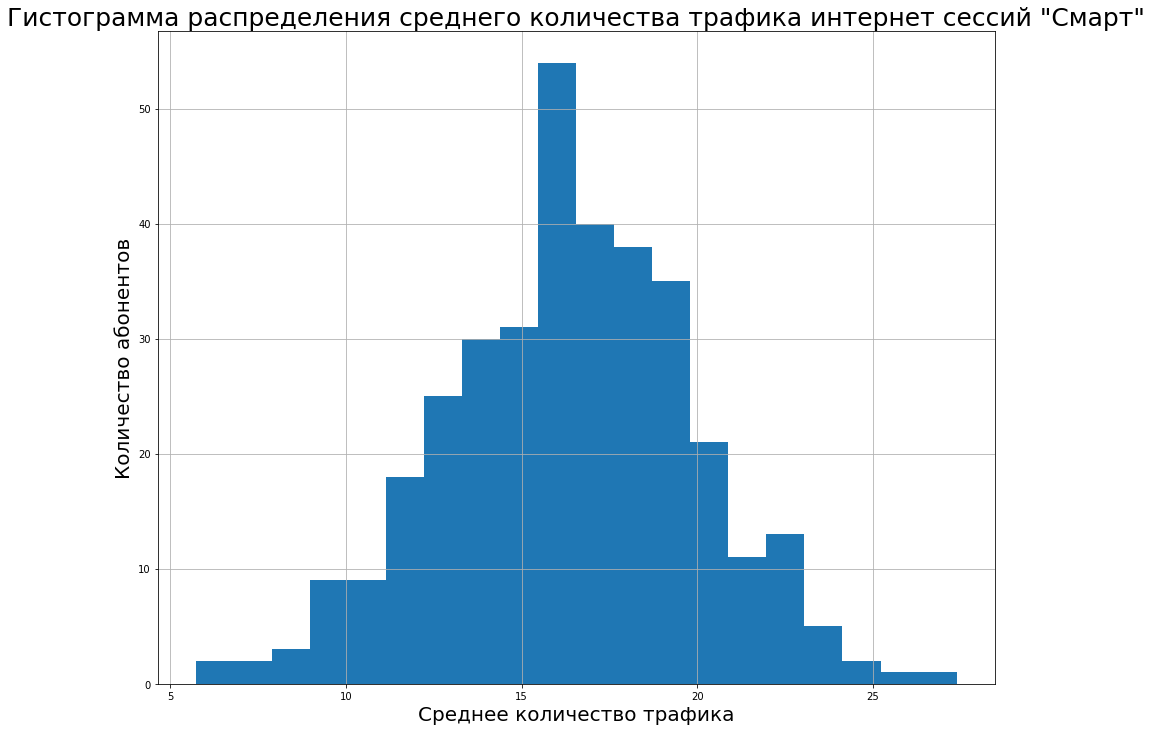

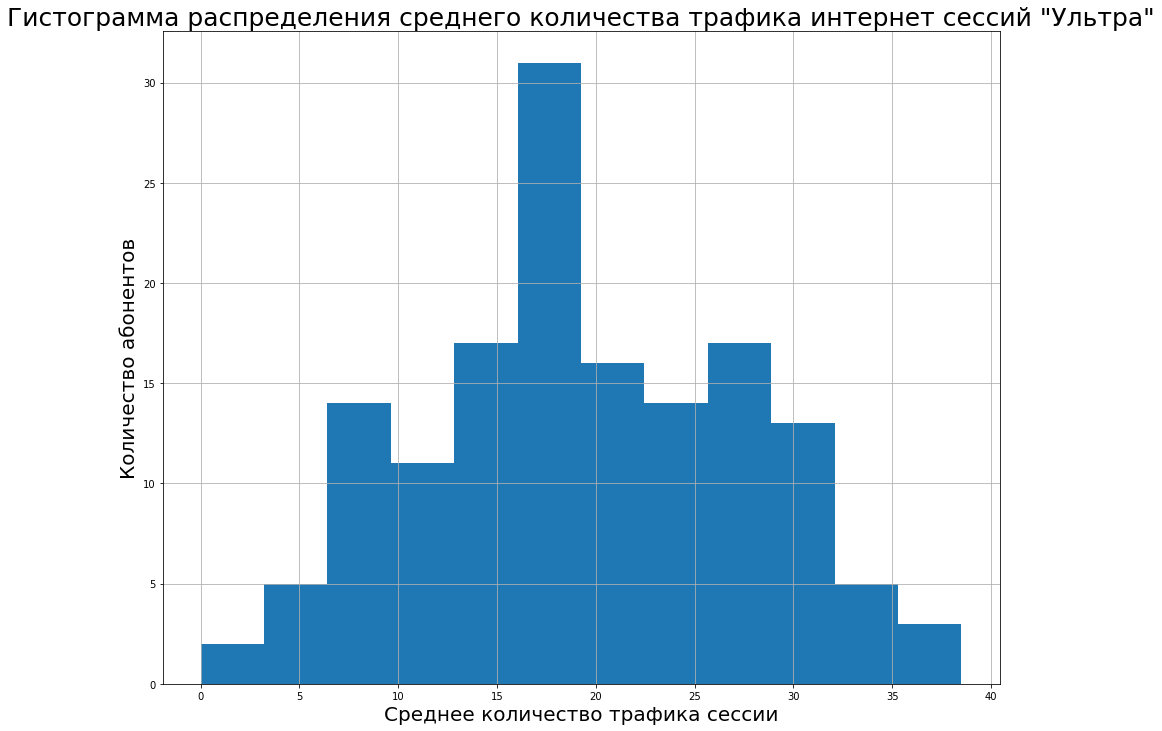

In [34]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values = 'Gb_sum',
                                       aggfunc = 'mean').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения среднего количества трафика интернет сессий "Смарт"', loc='center', fontsize = '25')
plt.xlabel('Среднее количество трафика', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 'Gb_sum',
                                       aggfunc = 'mean').hist(bins = 12, figsize = (15,12))
plt.title('Гистограмма распределения среднего количества трафика интернет сессий "Ультра"', loc='center', fontsize = '25')
plt.xlabel('Среднее количество трафика сессии', size = 20)
plt.ylabel('Количество абонентов', size = 20)
plt.show()

Данные по интернету распределены третьим образом - пик нормального распределения для тарифа "Смарт" находится рядом с лимитом, предусмотренным тарифом и, скорее, скошен влево, что соответствует картине, когда большиснтво пользователей предпочитает не переходить границы оплаченного. Однако, удивительным образом, пик приходится на значение ненамного превышающее предпоплаченный пакет. Это значит, что в среднем большая часть пользователей предпочитает докупить пару гигабайт. Абоненты тарифа "Ультра" в среднем используют почти столько же гигабайт(на самом деле, чуть-чуть больше), однако есть пик в районе значения 28 Гб. Возмонжо, это люди, которые используют мессенджеры чаще звонков и смс, либо и вовсем отказываются от последних в пользу интернет услуг(примерно столько в месяц уходит при активно использовании соцсетей для общения и обмена фотографиями, видео и т.д.)

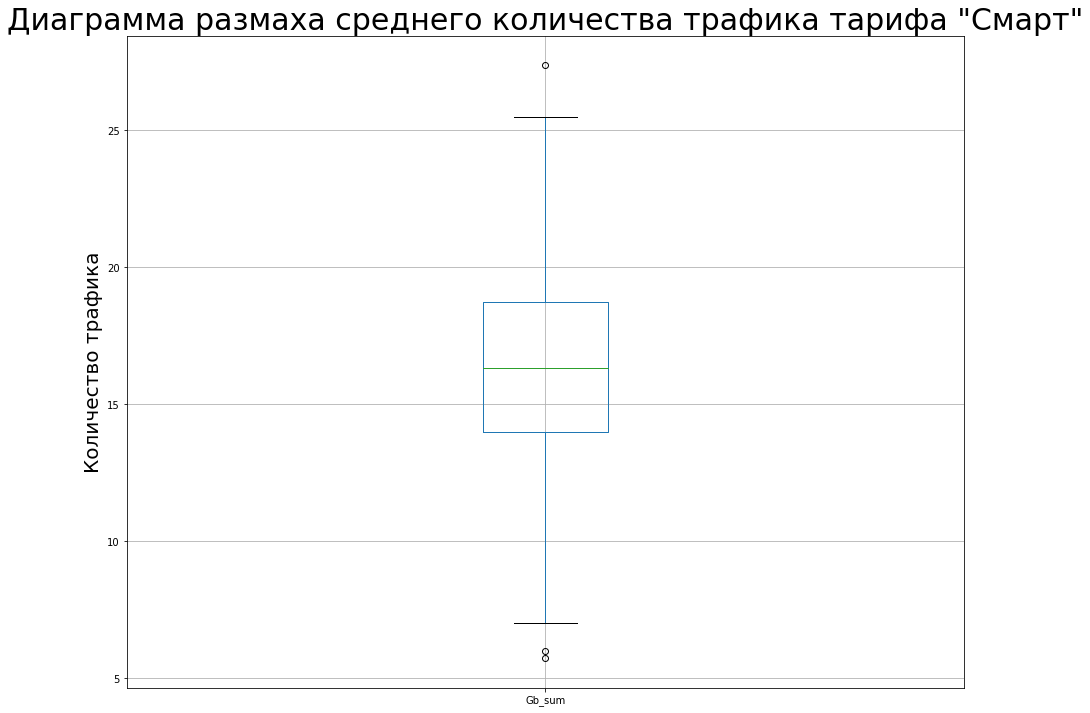

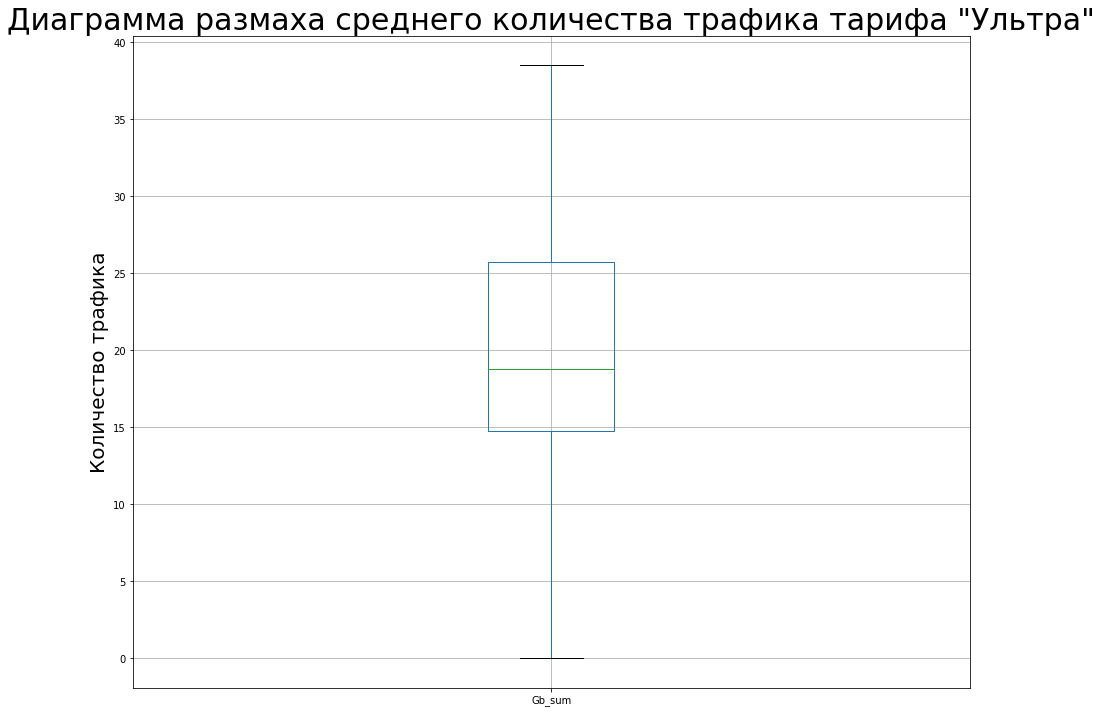

In [35]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values = 'Gb_sum', aggfunc = 'mean').boxplot(figsize = (15,12))
plt.title('Диаграмма размаха среднего количества трафика тарифа "Смарт"', loc='center', fontsize = '30')
plt.ylabel('Количество трафика', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 'Gb_sum', aggfunc = 'mean').boxplot(figsize = (15,12))
plt.title('Диаграмма размаха среднего количества трафика тарифа "Ультра"', loc='center', fontsize = '30')
plt.ylabel('Количество трафика', size = 20) 
plt.show()


На диаграмме размаха видно, что для тарифа "Смарт" есть выбивающиеся значения с обеих сторон. Значит, что есть активные пользователи мобильного интеренета, которым стоит задуматься о смене тарифа, и те, кто до сих пор отстает от современных реалий. Или просто предпочитает отдохнуть от бесконечнеого потока новостей =). Пользователи тарифа "Ультра" распределились почти эталонно - медианное значение немного левее, но нет ни одного выброса. Кстати, медианы для обоих тарифов находятся примерно на одном значении.

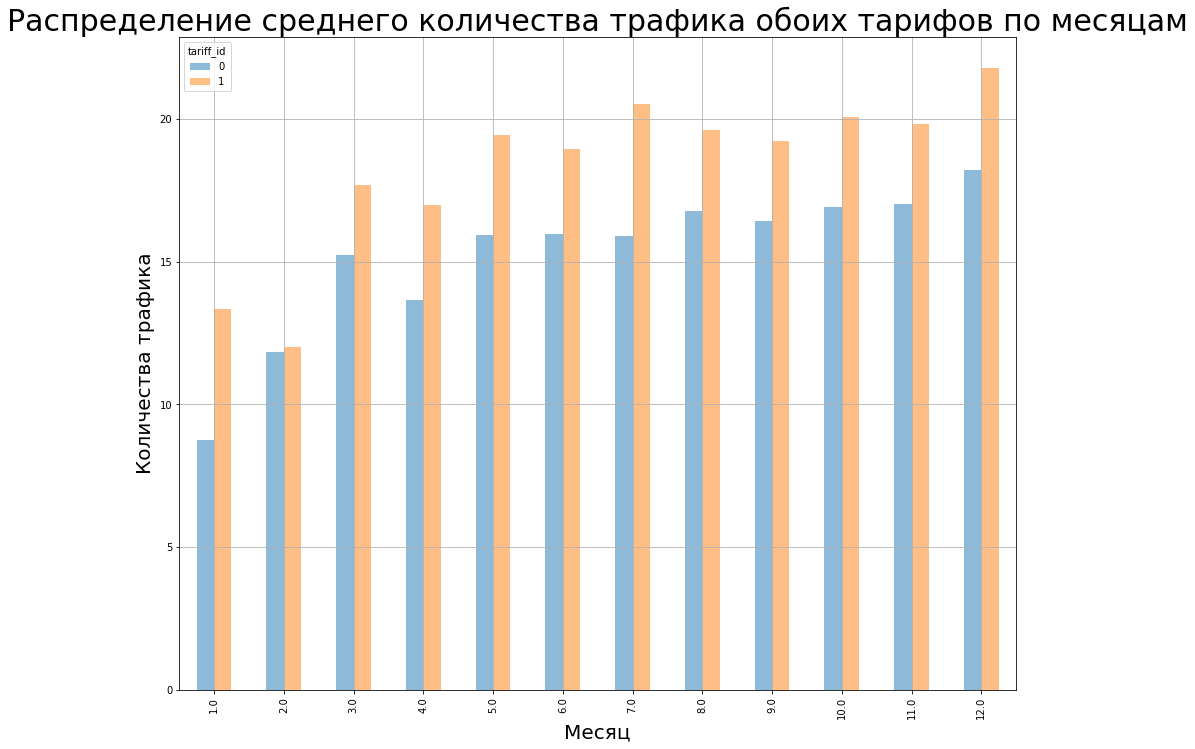

In [36]:
df.pivot_table(index='tariff_id', columns='month', values='Gb_sum', 
               aggfunc='mean').T.plot(kind='bar', alpha=0.5, grid = True, figsize = (15,12))
plt.title('Распределение среднего количества трафика обоих тарифов по месяцам', loc='center', fontsize = '30')
plt.xlabel('Месяц', size = 20) 
plt.ylabel('Количества трафика', size = 20) 
plt.show()

Что касается ситуации по месяцам, рост траффика обоих тарифов наблюдается с течением времени от начала года к концу. По прежнему самыми непопулярными месяцами являются январь и февраль. Вероятно, в нчале года пользователей у "Мегалайна" было меньше, чем к концу.

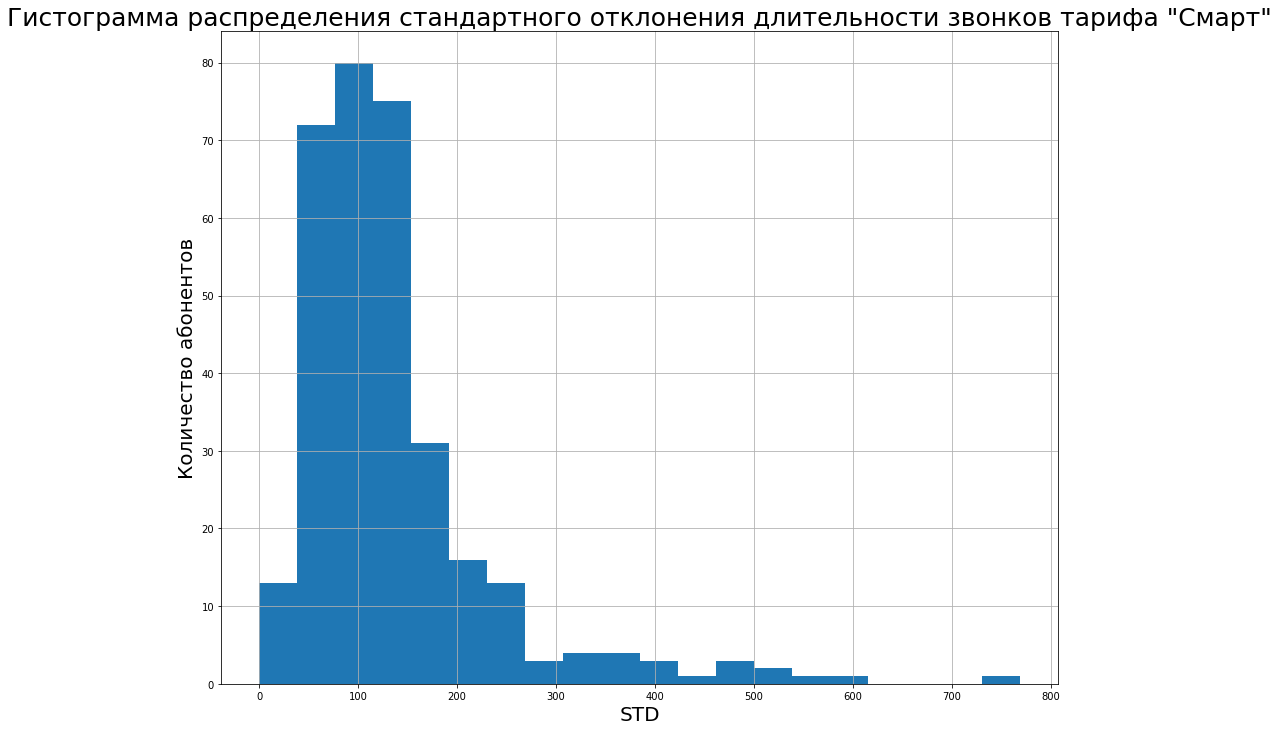

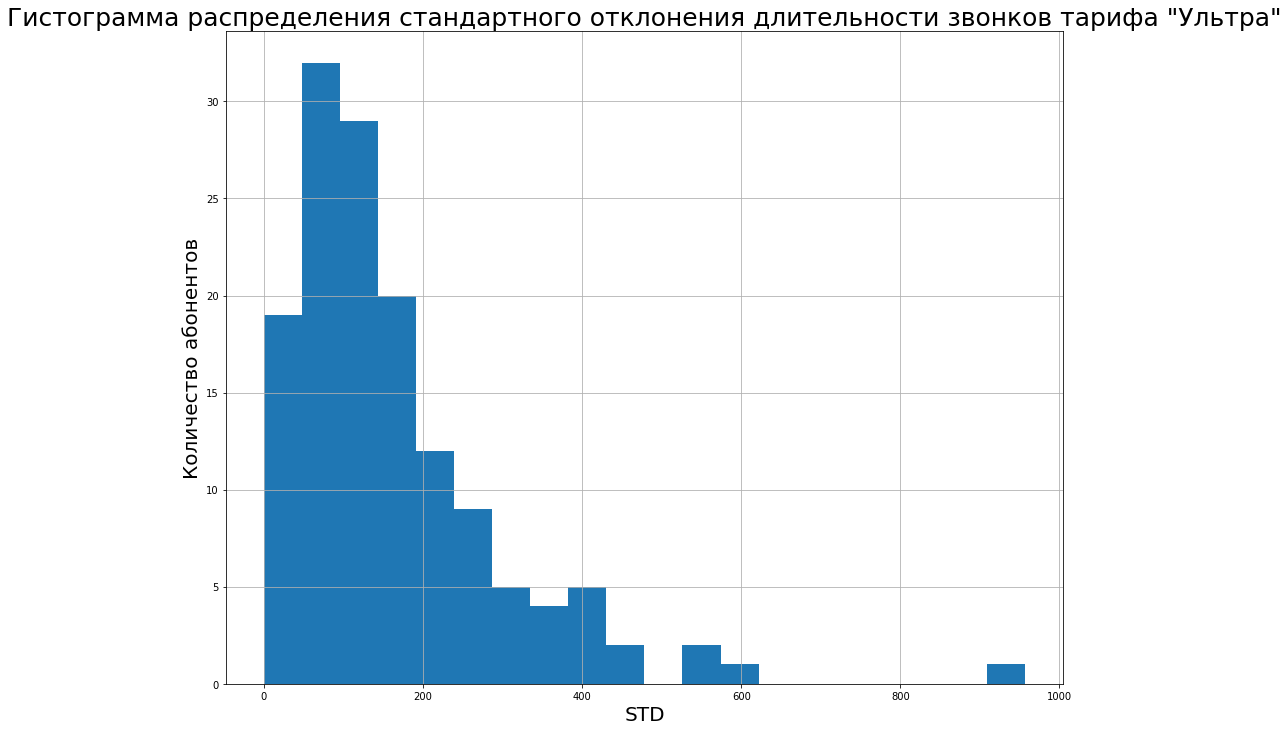

In [37]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values =
                                       'calls_sum', aggfunc = 'std').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения стандартного отклонения длительности звонков тарифа "Смарт"',
          loc='center', fontsize = '25')
plt.xlabel('STD', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 
                                        'calls_sum', aggfunc = 'std').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения стандартного отклонения длительности звонков тарифа "Ультра"',
          loc='center', fontsize = '25')
plt.xlabel('STD', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()

Рассмотрим теперь гистограммы стандартных отклонений для каждой из статей расхода по тарифу. Что можно наблюдать на гистограммах для стандартного отклонения? Например, что для тарифа "Смарт" наиболшее отклонение в районе 100 минут, как и для тарифа "Ультра". Стандартное отклонение характеризует на сколько исследуемая величина отклоняется от среднего значения. Значит, чаще всего пользователи исслудеумых тарифов предпочитают говорить по телефону меньше или не говорить вообще. Естественно, мы говорим о чаще всего в рамках отклонения от среднего.

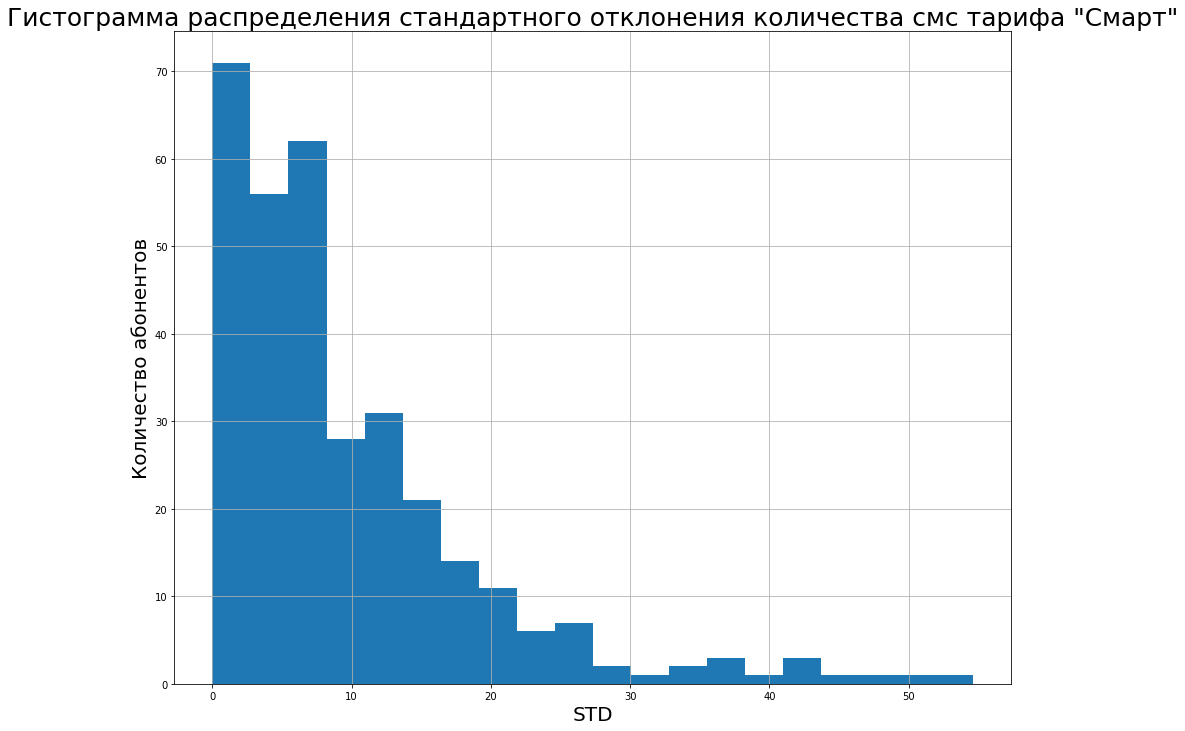

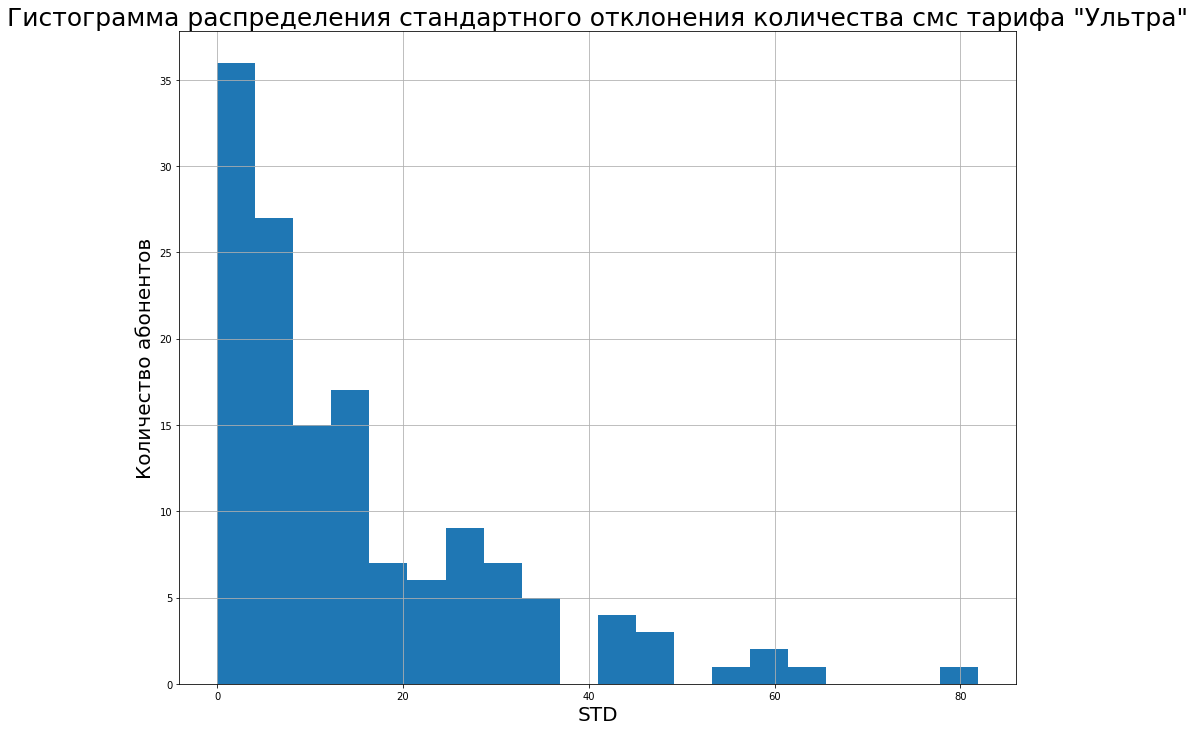

In [38]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values =
                                       'messages_count', aggfunc = 'std').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения стандартного отклонения количества смс тарифа "Смарт"',
          loc='center', fontsize = '25')
plt.xlabel('STD', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values =
                                       'messages_count', aggfunc = 'std').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения стандартного отклонения количества смс тарифа "Ультра"',
          loc='center', fontsize = '25')
plt.xlabel('STD', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()

Посмотрим теперь на гистограммы распределения стандартного отклонения для сообщений. Для обоих тарифов наблюдается пик в районе 0 - не удивительно, многие современнные пользователи предпочитают мессенджеры смскам. Однако, для пользователей тарифа "Смарт" есть пик в районе 7 и 12, а для абонентов "Ультра" - выбросы в район 17ти  и 30. Возмонжо, эти пользователи этого часто пользуются смс-сообщениями в качестве альтернативы принятия звонка(когда ты отклоняешь звонок отправляя смс стандартного вида, по типу "не могу говорить, я на совещании"). А может, это чья-то бабушка любит отправлять смс-открытки, заряжающие на хорошее настроение? =)

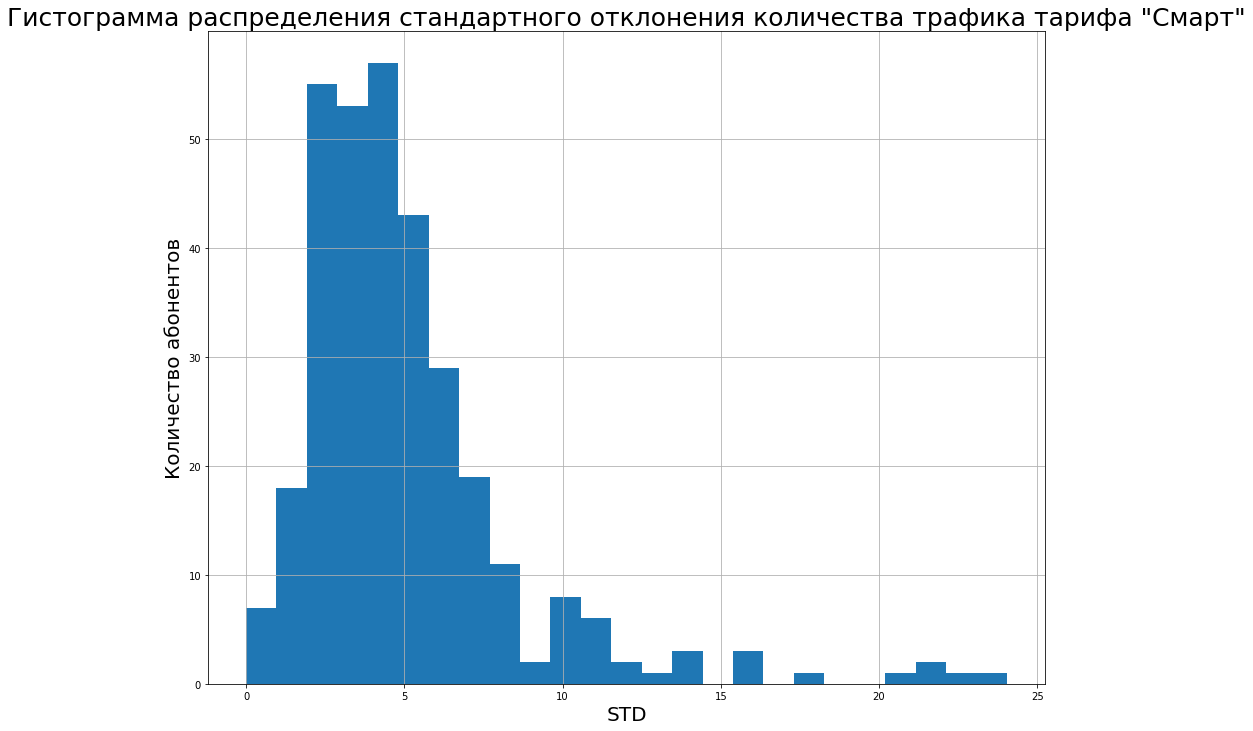

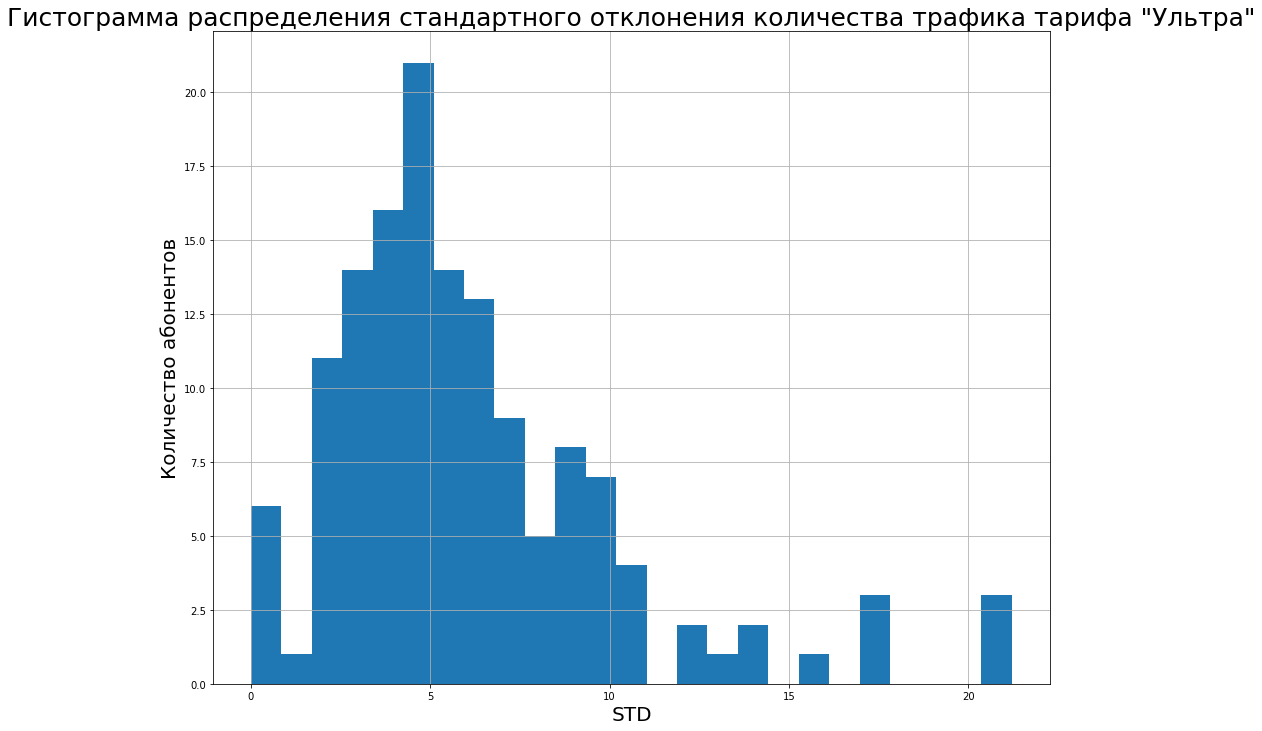

In [39]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values = 
                                       'Gb_sum', aggfunc = 'std').hist(bins = 25, figsize = (15,12))
plt.title('Гистограмма распределения стандартного отклонения количества трафика тарифа "Смарт"',
          loc='center', fontsize = '25')
plt.xlabel('STD', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 
                                       'Gb_sum', aggfunc = 'std').hist(bins = 25, figsize = (15,12))
plt.title('Гистограмма распределения стандартного отклонения количества трафика тарифа "Ультра"',
          loc='center', fontsize = '25')
plt.xlabel('STD', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()

Для интернет трафика картина получается следующая - для тарифа "Смарт" наибольшее стандартное отклонение находится в районе 2-3 ГБ. Возможно. эти пользователи выходят в интернет только для того,чтобы узнать какой-нибудь рецепт, прочитать краткие новости и посмотреть почту. Для тарифа "Ультра" есть два пика, характерный в районе 5ГБ и допольнительный в районе 8-9. Вероятно первый пик соответствует активному чаттингу в мессенджерах вместо смс, а второй еще и прослушиванию музыки в стриминговых сервисах.


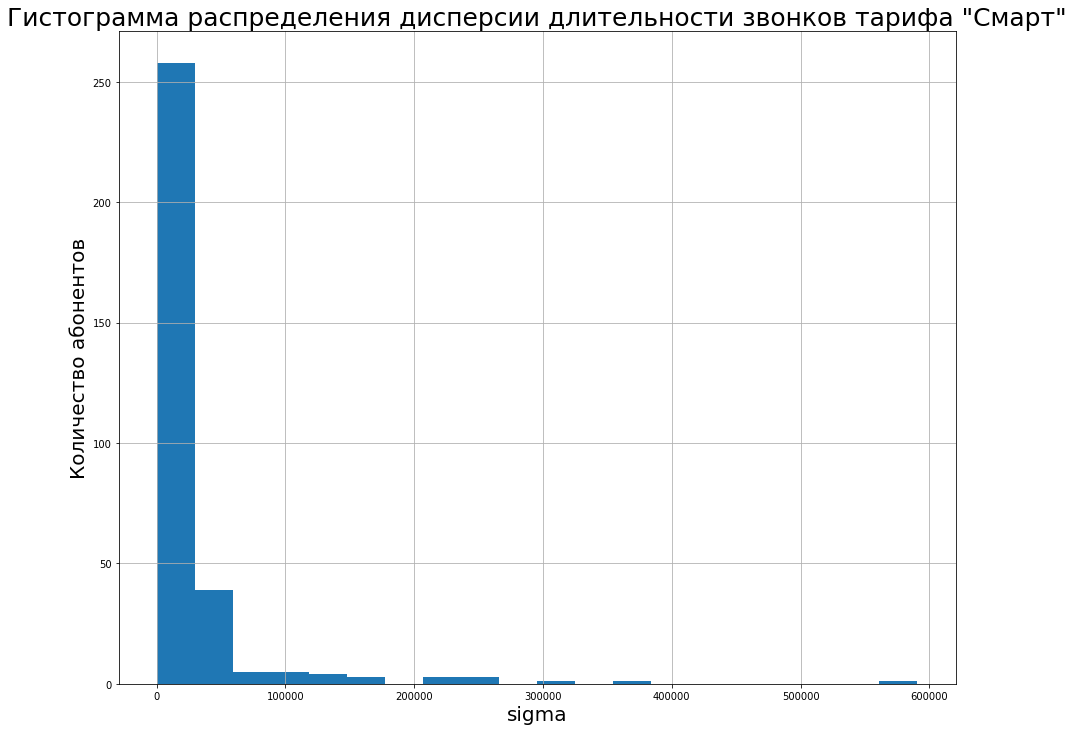

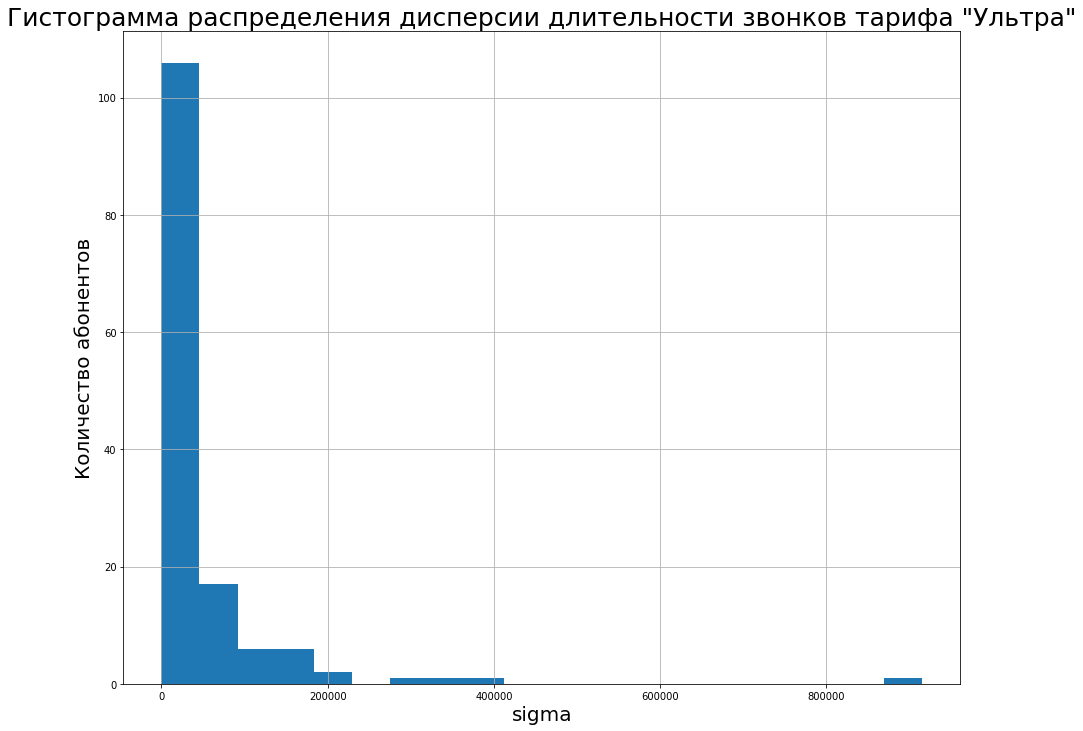

In [40]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values = 
                                       'calls_sum', aggfunc = 'var').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения дисперсии длительности звонков тарифа "Смарт"',
          loc='center', fontsize = '25')
plt.xlabel('sigma', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 
                                       'calls_sum', aggfunc = 'var').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения дисперсии длительности звонков тарифа "Ультра"',
          loc='center', fontsize = '25')
plt.xlabel('sigma', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()

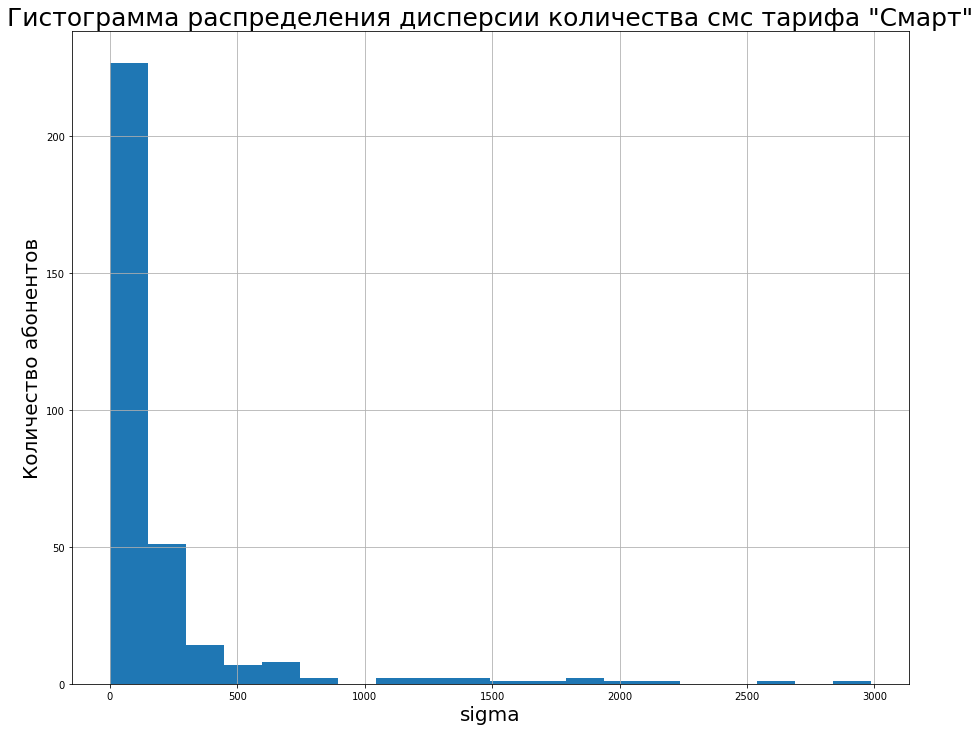

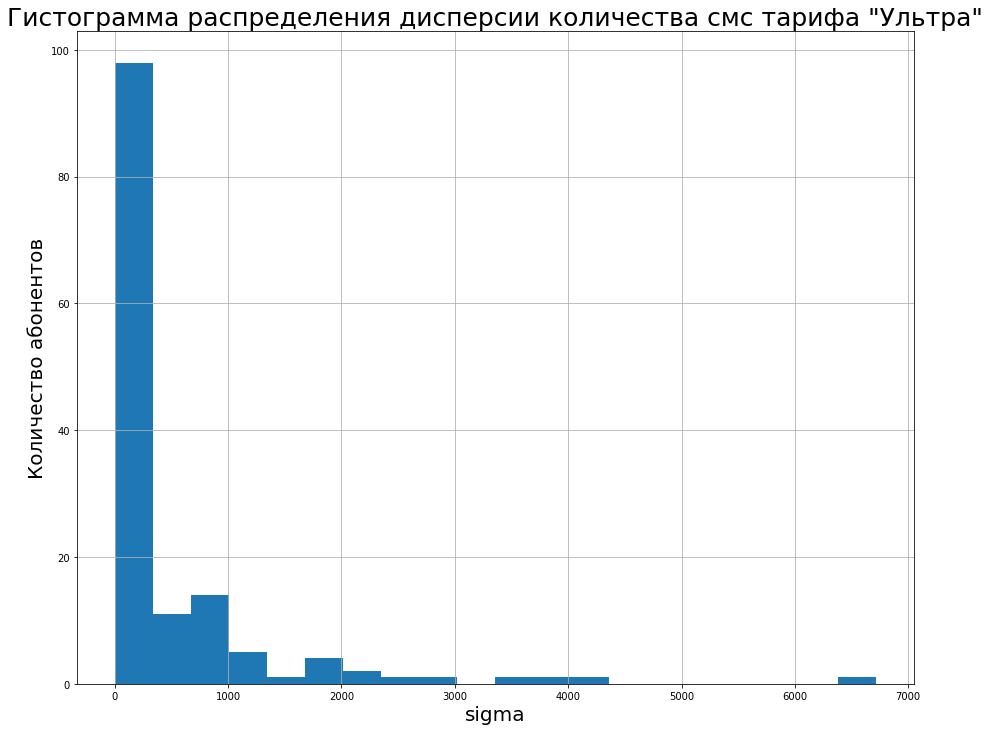

In [41]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values =
                                       'messages_count', aggfunc = 'var').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения дисперсии количества смс тарифа "Смарт"',
          loc='center', fontsize = '25')
plt.xlabel('sigma', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 
                                       'messages_count', aggfunc = 'var').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения дисперсии количества смс тарифа "Ультра"',
          loc='center', fontsize = '25')
plt.xlabel('sigma', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()

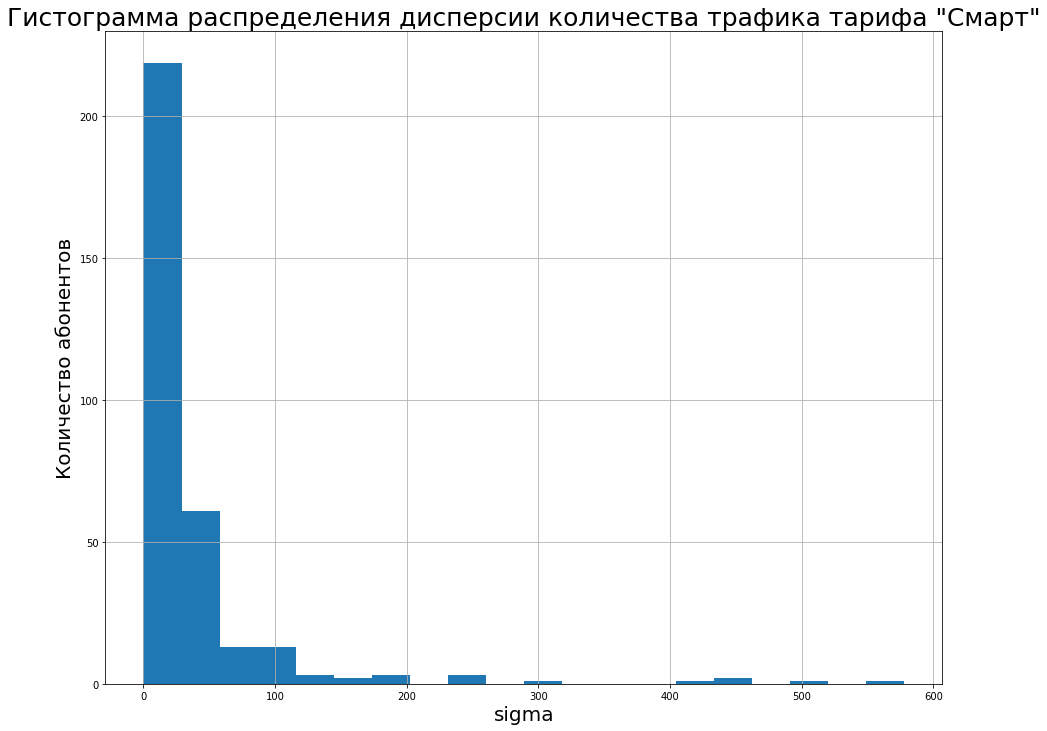

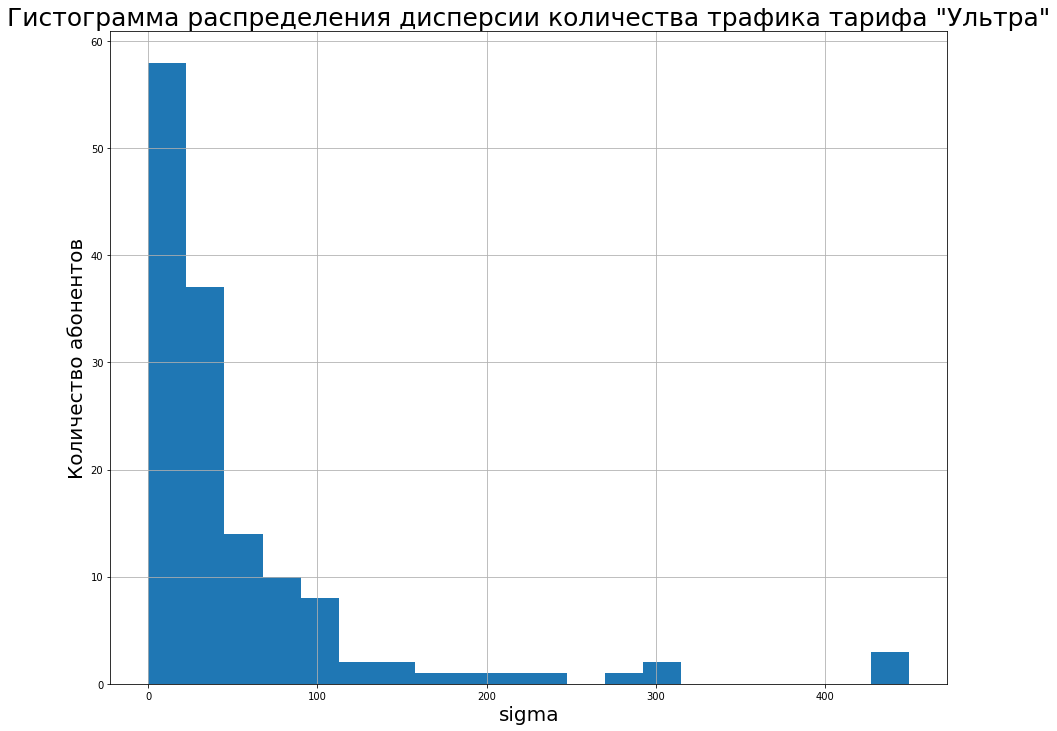

In [42]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values = 'Gb_sum', aggfunc = 'var').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения дисперсии количества трафика тарифа "Смарт"',
          loc='center', fontsize = '25')
plt.xlabel('sigma', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 'Gb_sum', aggfunc = 'var').hist(bins = 20, figsize = (15,12))
plt.title('Гистограмма распределения дисперсии количества трафика тарифа "Ультра"',
          loc='center', fontsize = '25')
plt.xlabel('sigma', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()

Все приведенные зависимости дисперсий для показателей расходов по тарифу достигают максимальных значений около нуля. Делаем вывод следующего характера: максимальная среднеквадратичная ошибка(или отклонение)  сосредоточена вокруг пользоватлей, которые не используют отдельные опции своих тарифов(либо звонки, либо смс, илбо интернет трафик)


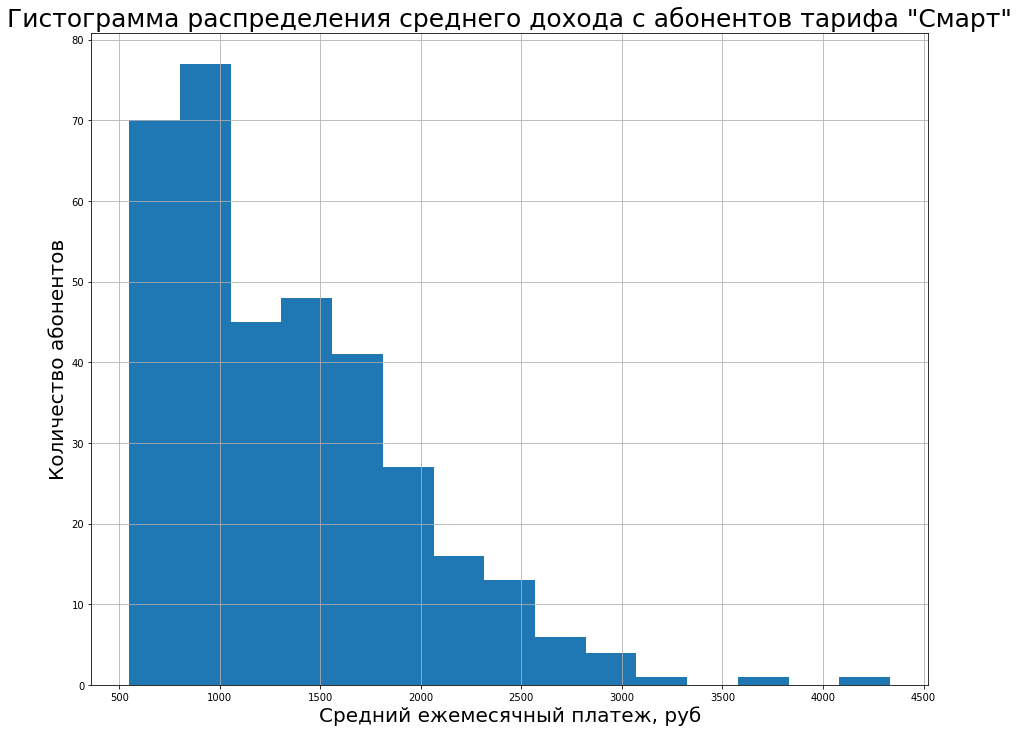

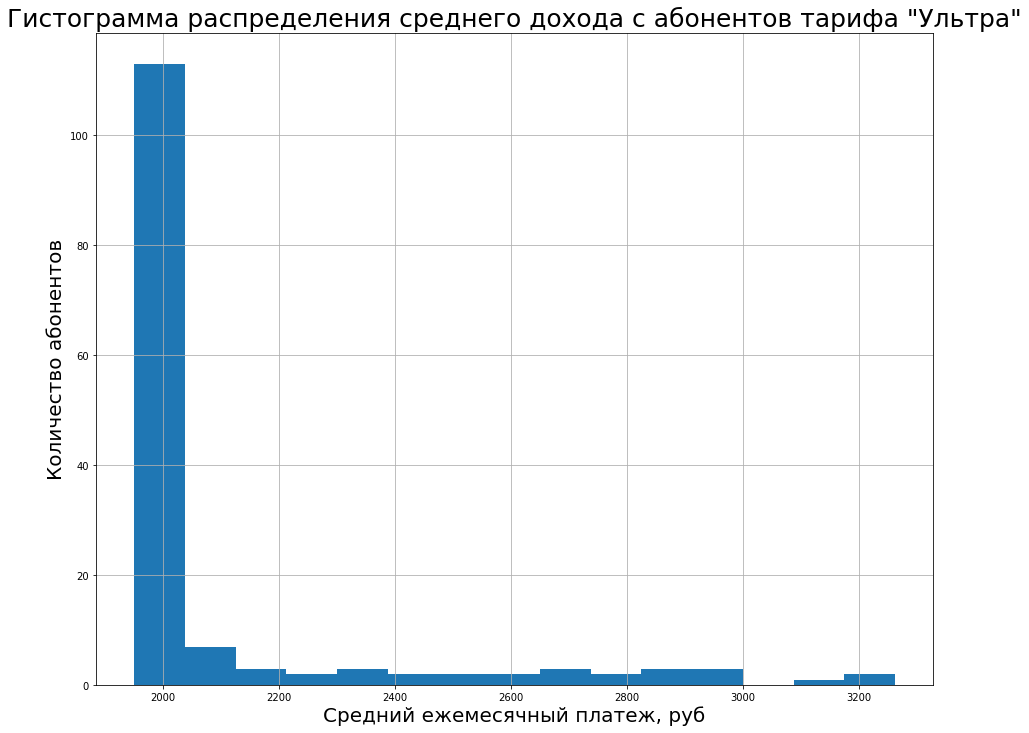

In [43]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values =
                                    'income_per_month', aggfunc = 'mean').hist(bins = 15, figsize = (15,12))
plt.title('Гистограмма распределения среднего дохода с абонентов тарифа "Смарт"', loc='center', fontsize = '25')
plt.xlabel('Средний ежемесячный платеж, руб', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 
                                       'income_per_month', aggfunc = 'mean').hist(bins = 15, figsize = (15,12))
plt.title('Гистограмма распределения среднего дохода с абонентов тарифа "Ультра"', loc='center', fontsize = '25')
plt.xlabel('Средний ежемесячный платеж, руб', size = 20)
plt.ylabel('Количество абонентов', size = 20) 
plt.show()

Вернемся к самому главному ради чего всё затевалось - к прибыли с клиентов. судя по гистограммам, пользователи тарифа "смарт" для оператора выгднее.

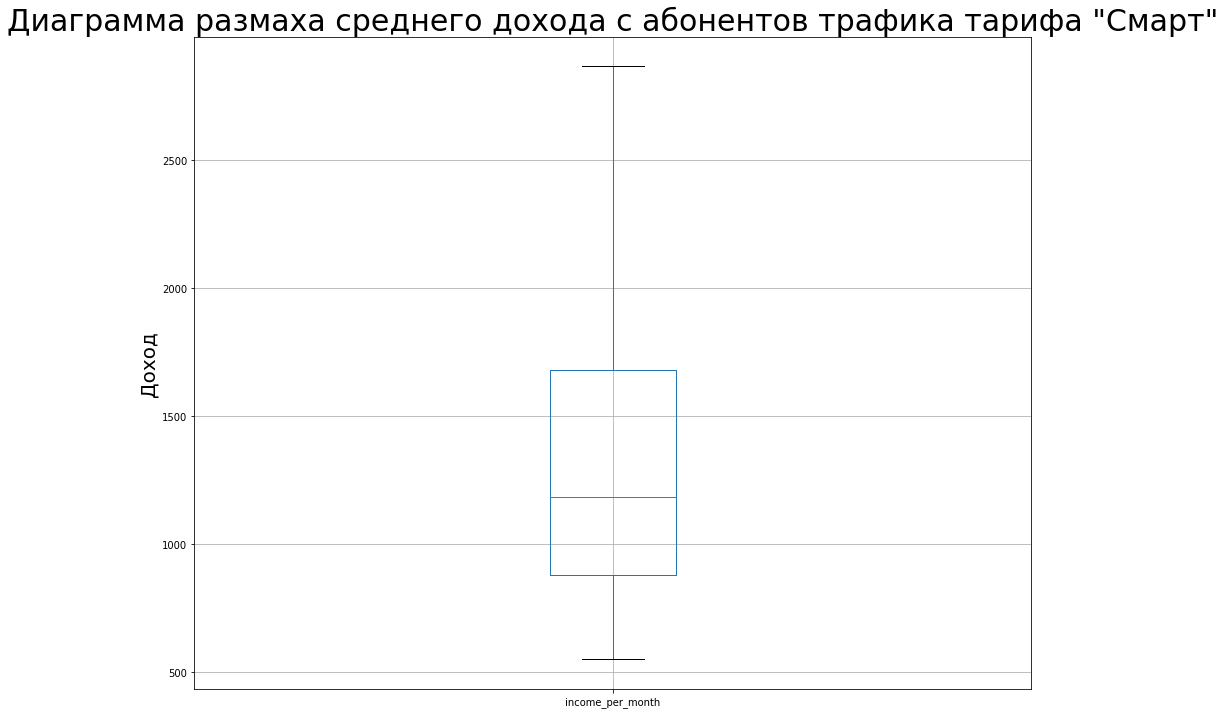

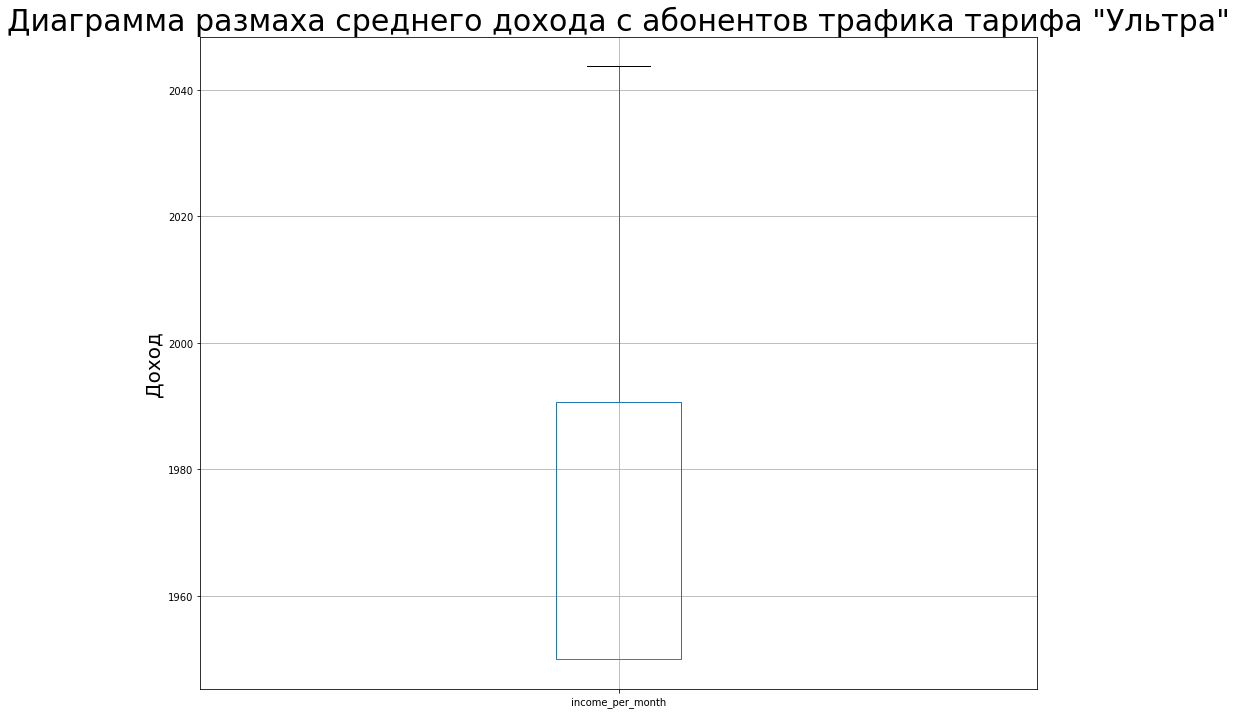

In [44]:
df.query('tariff_id == 0').pivot_table(index = 'user_id', values =
                                       'income_per_month', aggfunc = 'mean').boxplot(figsize = (15,12), showfliers=False)
plt.title('Диаграмма размаха среднего дохода с абонентов трафика тарифа "Смарт"', loc='center', fontsize = '30')
plt.ylabel('Доход', size = 20) 
plt.show()
print()
df.query('tariff_id == 1').pivot_table(index = 'user_id', values = 
                        'income_per_month', aggfunc = 'mean').boxplot(figsize = (15,12), showfliers=False)
plt.title('Диаграмма размаха среднего дохода с абонентов трафика тарифа "Ультра"', loc='center', fontsize = '30')
plt.ylabel('Доход', size = 20) 
plt.show()

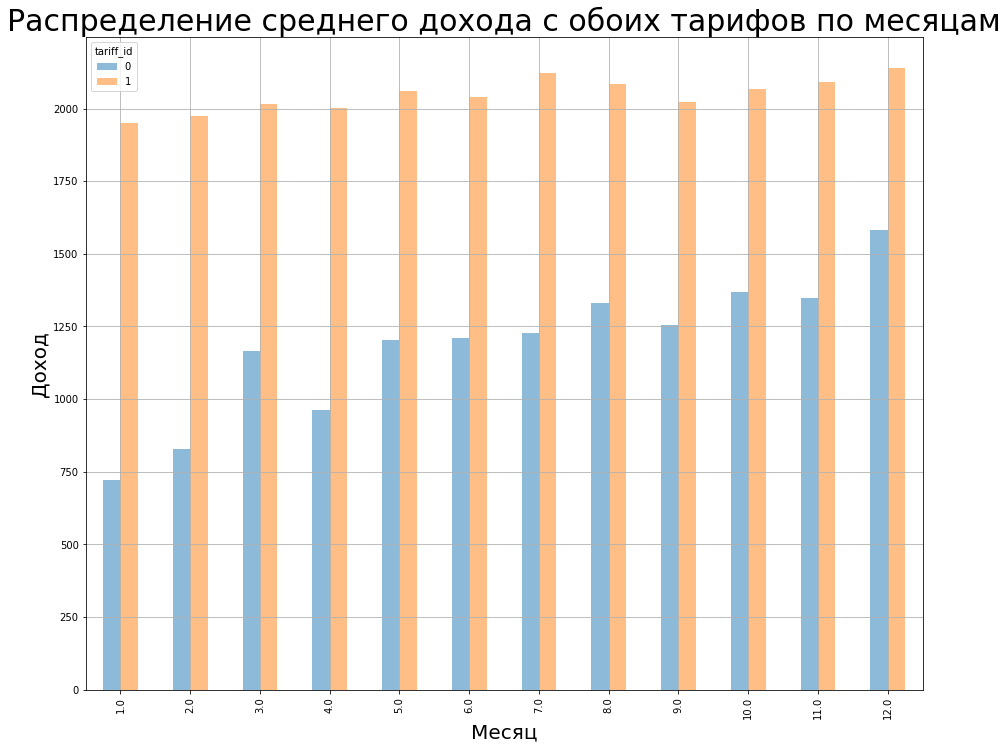

In [45]:
df.pivot_table(index='tariff_id', columns='month', values='income_per_month',
               aggfunc='mean').T.plot(kind='bar', alpha=0.5,grid = True, figsize = (15,12))
plt.title('Распределение среднего дохода с обоих тарифов по месяцам', loc='center', fontsize = '30')
plt.xlabel('Месяц', size = 20) 
plt.ylabel('Доход', size = 20)
plt.show()

Диаграмма размаха подтверждает выдвинутое ранее утверждение. Все значения очевидно завышающие доход оператора с тарифа "Ультра" по сравнению со "Смартом" больше похожи на выбросы. Однако, если смотреть по месяцам, в среднем, на тариф "Ультра" польхователи тратят примертно в 2 раза больше денег. Почему получается так? Потому что "в среднем за месяц" тариф "ультра" стоит дороже. Однако при выборе тарифа "Смарт" пользователь чаще оказывается в ситуации, когда ему требуется оплатить дополнительные услуги, что приводит к незапланированным тратам, которые, в свою очередь,поднимают выгодность тарифа "Смарт" для оператора. Выходит, что дешевый тариф оказался для оператора более интересным с точки зрения заработка и привлечения новых клиентов.

В ходе детального анализа данных выяснилось, что для оператора "Мегалайн" выгоднее продвигать тариф "Смарт" и пользователям рекламировать и предлагать в первую очередь именно его. Так вышло из-за активного использования допольнительных опций пользователями базового тарифа при том, что средние значения расходов минут, смс и трфика в интернете различаются, но не столь значительно( в основном различия продиктованы изначальными ограничениями по тарфиу)

## Проверка гипотез

Проверим следующие гипотезы на их истинность:

-средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

-средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

### Гипотеза №1

Гипотеза звучит так: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Для нас она будет сформулирована несколько более понятным языком - средняя выручка с пользователей тарифа "Смарт" равна средней выручке тарифа "Ультра". Проверим сие утрверждение на истинность, для этого воспользуемся проверкой методом scipy.stats.ttest_ind. У нас нет оснований полагать, что выборки взять из схожих по параметрам совокупностей,поэтому укажем в аргументе equal_var = False. Величину значимости alpha зададим как 5%. Выполним проверку нулевой гипотезы:

Итак, наши гипотезы звучат следующим образом:

Нулевая гипотеза(Н0): средние выручки по обоим тарифам РАВНЫ.

Ненулевая(обратная) гипотеза (Н1): средние выручки по тарифам ОТЛИЧАЮТСЯ друг от друга(НЕ РАВНЫ).

Проверим нулевую гипотезу. Если она окажется неверна(у нас не будет оснований полагать её верность), мы будем полагать верность обратной гипотезы.

In [46]:
df_0 = df.query('tariff_id == 0')
df_1 = df.query('tariff_id == 1')
alpha = 0.05

results = st.ttest_ind(df_0['income_per_month'], df_1['income_per_month'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отклонить нулевую гипотезу")


p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


Нулевая гипотеза звучала как :"средняя выручка с пользователей тарифа "Смарт" равна средней выручке тарифа "Ультра". В нулевой гипотезе обызательно должно быть равенство, поэтому она выбрана следующим образом. Однако, проверка этой гипотезы показала отрицательный результат, у нас нет оснований полагать,что гипотеза верная, так как полученное значение p-value ничтожно мало. Значит есть основания положить, что верна гипотеза Н1 - средняя выручка с пользователей тарифа "Смарт" НЕ равна средней выручке тарифа "Ультра

### Гипотеза №2

Нулевая гипотеза №2 звучит так - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. Помним, что в нулевой гипотезе мы должны использовать знак равенства. Проверим это утверждение тем же методом(ведь мы сравниваем среднее по двум выборкам)

Воизбежание разночтений сформулируем наши гипотезы:

Нулевая гипотеза(Н0): средняя выручка пользователей из Москвы РАВНА выручке пользователей из других регионов.

Ненулевая(обратная) гипотеза (Н1): средние выручки пользователей из Москвы и пользователей из других регионов ОТЛИЧАЮТСЯ (НЕ РАВНЫ).

In [47]:
df= df.merge(df_users[['city', 'user_id']], how = 'inner', on = 'user_id')
display(df)
df_Moscow = df.query('city == "Москва"')
df_Other = df.query('city != "Москва"')
display(df_Moscow)
display(df_Other)

,user_id,month,calls_count,calls_sum,messages_count,Gb_sum,tariff_id,income_per_month,city
0,1000,5.0,22.0,159.0,22.0,3.0,1,1950.0,Краснодар
1,1000,6.0,43.0,172.0,60.0,23.0,1,1950.0,Краснодар
2,1000,7.0,47.0,340.0,75.0,14.0,1,1950.0,Краснодар
3,1000,8.0,52.0,408.0,81.0,14.0,1,1950.0,Краснодар
4,1000,9.0,58.0,466.0,57.0,15.0,1,1950.0,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,0.0,17.0,11.0,0,550.0,Санкт-Петербург
3210,1489,9.0,0.0,0.0,32.0,17.0,0,950.0,Санкт-Петербург
3211,1489,10.0,0.0,0.0,21.0,20.0,0,1550.0,Санкт-Петербург
3212,1489,11.0,0.0,0.0,20.0,18.0,0,1150.0,Санкт-Петербург


,user_id,month,calls_count,calls_sum,messages_count,Gb_sum,tariff_id,income_per_month,city
8,1001,11.0,59.0,430.0,0.0,19.0,0,1350.0,Москва
9,1001,12.0,63.0,414.0,0.0,14.0,0,550.0,Москва
17,1003,8.0,55.0,380.0,37.0,9.0,1,1950.0,Москва
18,1003,9.0,134.0,961.0,91.0,13.0,1,1950.0,Москва
19,1003,10.0,108.0,855.0,83.0,15.0,1,1950.0,Москва
...,...,...,...,...,...,...,...,...,...
3120,1490,8.0,45.0,346.0,50.0,17.0,0,950.0,Москва
3121,1490,9.0,44.0,322.0,48.0,15.0,0,550.0,Москва
3122,1490,10.0,42.0,312.0,45.0,21.0,0,1750.0,Москва
3123,1490,11.0,38.0,282.0,47.0,19.0,0,1350.0,Москва


,user_id,month,calls_count,calls_sum,messages_count,Gb_sum,tariff_id,income_per_month,city
0,1000,5.0,22.0,159.0,22.0,3.0,1,1950.0,Краснодар
1,1000,6.0,43.0,172.0,60.0,23.0,1,1950.0,Краснодар
2,1000,7.0,47.0,340.0,75.0,14.0,1,1950.0,Краснодар
3,1000,8.0,52.0,408.0,81.0,14.0,1,1950.0,Краснодар
4,1000,9.0,58.0,466.0,57.0,15.0,1,1950.0,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,0.0,17.0,11.0,0,550.0,Санкт-Петербург
3210,1489,9.0,0.0,0.0,32.0,17.0,0,950.0,Санкт-Петербург
3211,1489,10.0,0.0,0.0,21.0,20.0,0,1550.0,Санкт-Петербург
3212,1489,11.0,0.0,0.0,20.0,18.0,0,1150.0,Санкт-Петербург


In [48]:
alpha = 0.05

results = st.ttest_ind(df_Moscow['income_per_month'], df_Other['income_per_month'], equal_var = True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отклонить нулевую гипотезу")


p-значение: 0.531666503831252
Нет оснований отклонить нулевую гипотезу


Получается, у нас есть все основания полагать, что в Москве средняя выручка такая же, как и в регионах. Интересное наблюдение!

## Вывод

В ходе исследования было выяснено, что оператору не стоит сосредотачиваться на Москве и на премиальных тарифах. Выгоднее будет вложиться в развитие тарифа "Смарт" не акцентируя внимания на городе, а также,подкорректировать тариф "Ультра" для получения допольнительной прибыли с пользователей,например, уменьшить количество минут, но, вместе с тем, уменьшить и сумму ежемесячного платежа. Сосредоточиться на рекламной компании стоит в начале года, исследование показало, что пользователи в это время наименее активны и начинают разгоняться примерно к апреляю-маю.